## Looking at One Dataset

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import ranksums, spearmanr
%load_ext rpy2.ipython

### Color hexadecimal values for each dataset:
"Dartmouth" = "#1F78B4",
"DIABIMMUNE" = "#33A02C",
"Hayden" = "#D73027",
"TEDDY" = "#FF7F00"

### Dartmouth

In [2]:
infile_metaphlan = "/dartfs/rc/lab/R/RossB/DartCF_infant_meta/Results/dart_CF_metaphlan_combined_g_relative_abundance.xlsx"
df_species_rel_ab = pd.read_excel(infile_metaphlan, index_col=0)
df_species_rel_ab.columns = [x.replace("_metaphlan_rel_ab_w_read_stats.txt","") for x in df_species_rel_ab]
df_species_rel_ab.index = [x.split("|")[-1] for x in df_species_rel_ab.index]

infile_metaphlan = "/dartfs/rc/lab/R/RossB/DartCF_infant_meta/Results/dart_CF_metaphlan_combined_g_estimated_number_of_reads_from_the_clade.xlsx"
df_species_totals = pd.read_excel(infile_metaphlan,index_col=0)
df_species_totals.columns = [x.replace("_metaphlan_rel_ab_w_read_stats.txt","") for x in df_species_totals]

df_tnaA = pd.read_csv("/dartfs/rc/lab/R/RossB/DartCF_infant_meta/Results/dart_CF_Diamond_TnaA_read_sum_30_Genus.csv",index_col=0)
df_tnaA.columns = [x.replace("_Diamond_TnaA.tsv","") for x in df_tnaA.columns]
print(df_tnaA)

df_tnaA_genus = pd.read_csv("/dartfs/rc/lab/R/RossB/DartCF_infant_meta/Results/dart_CF_Diamond_TnaA_best_hit_80_Genus.csv",index_col=0)
df_tnaA_genus.columns = [x.replace("_Diamond_TnaA.tsv","") for x in df_tnaA_genus.columns]
print(df_tnaA_genus)

          021721_142  021721_183  021721_170  021721_129  021721_172  \
read_sum         431           5          24         195          63   

          021721_74  021721_68  021721_107  021721_15  021721_27  ...  \
read_sum       1015       1029         185         13        219  ...   

          021721_184  021721_116  021721_38  021721_186  021721_104  \
read_sum         854          73       6285         703         749   

          021721_189  021721_167  021721_159  021721_102  021721_23  
read_sum         879         581         256         110        470  

[1 rows x 195 columns]
                    021721_142  021721_183  021721_170  021721_129  \
Shigella                 387.0         0.0         0.0        71.0   
Bacteroides                5.0         0.0         0.0         0.0   
Escherichia               35.0         0.0         0.0         4.0   
Porphyromonas              0.0         1.0         0.0        59.0   
Haemophilus                0.0         0.0         

In [4]:
def sum_species_counts(df_tnaA_genus, species_to_merge, new_species_name):
    missing_species = [species for species in species_to_merge if species not in df_tnaA_genus.index]
    if missing_species:
        raise ValueError(f"Missing species in DataFrame: {missing_species}")
    df_tnaA_genus.loc[new_species_name] = df_tnaA_genus.loc[species_to_merge].sum()
    species_to_drop = [species for species in species_to_merge if species != new_species_name]
    df_tnaA_genus = df_tnaA_genus.drop(species_to_drop)
    return df_tnaA_genus

def get_genus_hits(df_tnaA_genus, df_species_totals, genera_oi):
    df_genus_oi = df_tnaA_genus.loc[genera_oi,:].T
    df_genus_oi = df_genus_oi.merge(df_species_totals.T["k__Bacteria"], left_index=True, right_index=True)
    for genus in genera_oi:
        df_genus_oi["read_frac_{}".format(genus)] = df_genus_oi[genus] / df_genus_oi["k__Bacteria"] 
    return df_genus_oi

def add_bulk_hits(df, df_tnaA):
    df = df.merge(df_tnaA.T, left_index=True, right_index=True)
    df["read_sum_frac"] = df["read_sum"] / df["k__Bacteria"]
    return df

def add_metaphlan(df, df_species_rel_ab, genera_oi = None):
    if genera_oi is None:
        df_metaphlan = df_species_rel_ab.T
    else:
        df_metaphlan = df_species_rel_ab.query('index in @genera_oi').T
    return df.merge(df_metaphlan, left_index=True, right_index=True)

def add_metadata(df):
    indir = Path("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/CF_Metagenomics_Manuscript/Tables")
    infile_meta = indir / "All_metadata_with_individuals_final_231222.csv"
    df_meta = pd.read_csv(infile_meta)
    df_meta = df_meta[["Sample","Individual","Age"]]
    df_meta.index = df_meta["Sample"]
    df_meta.drop(columns=["Sample"],inplace=True)
    return df.merge(df_meta, left_index=True, right_index=True)

df_tnaA_genus = sum_species_counts(df_tnaA_genus, ['Escherichia', 'Shigella'], 'Escherichia')
df_dart = get_genus_hits(df_tnaA_genus, df_species_totals, ["Bacteroides","Escherichia"])
df_dart = add_bulk_hits(df_dart, df_tnaA)
df_dart = add_metaphlan(df_dart, df_species_rel_ab, ["g__Bacteroides","g__Escherichia"])
df_dart = add_metadata(df_dart)
df_dart = df_dart.query("Age <= 30")
print(df_dart)


%Rpush df_dart

           Bacteroides  Escherichia  k__Bacteria  read_frac_Bacteroides  \
021021_01          0.0          5.0      1883825           0.000000e+00   
021021_03          6.0        149.0      1940521           3.091953e-06   
021721_01          1.0        480.0      8970056           1.114820e-07   
021721_02          0.0       2764.0     12237960           0.000000e+00   
021721_03          7.0        201.0      8004961           8.744577e-07   
...                ...          ...          ...                    ...   
021721_95          8.0        592.0     13172727           6.073154e-07   
021721_96          2.0         41.0     12229790           1.635351e-07   
021721_97          0.0        606.0     16986071           0.000000e+00   
021721_98          0.0        249.0     12815885           0.000000e+00   
021721_99         12.0          2.0     12440941           9.645573e-07   

           read_frac_Escherichia  read_sum  read_sum_frac  g__Escherichia  \
021021_01           2.

── Attaching core tidyverse packages ────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

	Spearman's rank correlation rho

data:  df_dart$Age and log10(df_dart$read_sum_frac + 1e-07)
S = 1191305, p-value = 0.205
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.09310454 

`geom_smooth()` using formula = 'y ~ x'


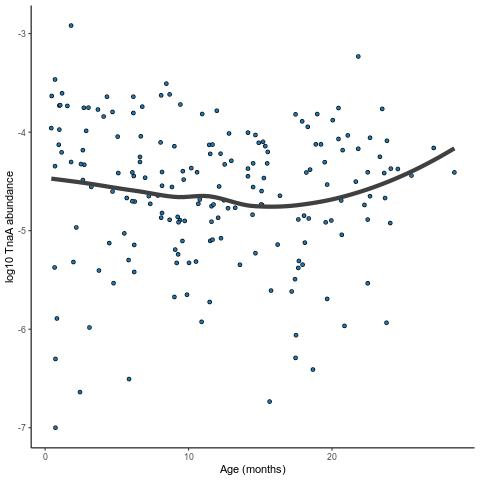

In [5]:
%%R
library(tidyverse)
library(ggplot2)
print(cor.test(df_dart$Age, log10(df_dart$read_sum_frac + 1e-7), method="spearman"))
p1 <- ggplot(df_dart, aes(x = Age, y = log10(read_sum_frac + 1e-7))) + geom_point(pch=21, fill="#1F78B4") + theme_classic() + geom_smooth(se=FALSE, color="#404040", lwd=2, alpha=10, method="loess") +
                ylab("log10 TnaA abundance") + xlab("Age (months)")
print(p1)

# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Dart_total_TnaA_Abundance_over_time_240417.pdf", p1, width = 4, height = 4)


R[write to console]: 
Attaching package: ‘gridExtra’


R[write to console]: The following object is masked from ‘package:dplyr’:

    combine




[1] 0.01646522
[1] 0.8230188
[1] 0.2860567
[1] 7.223782e-05
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


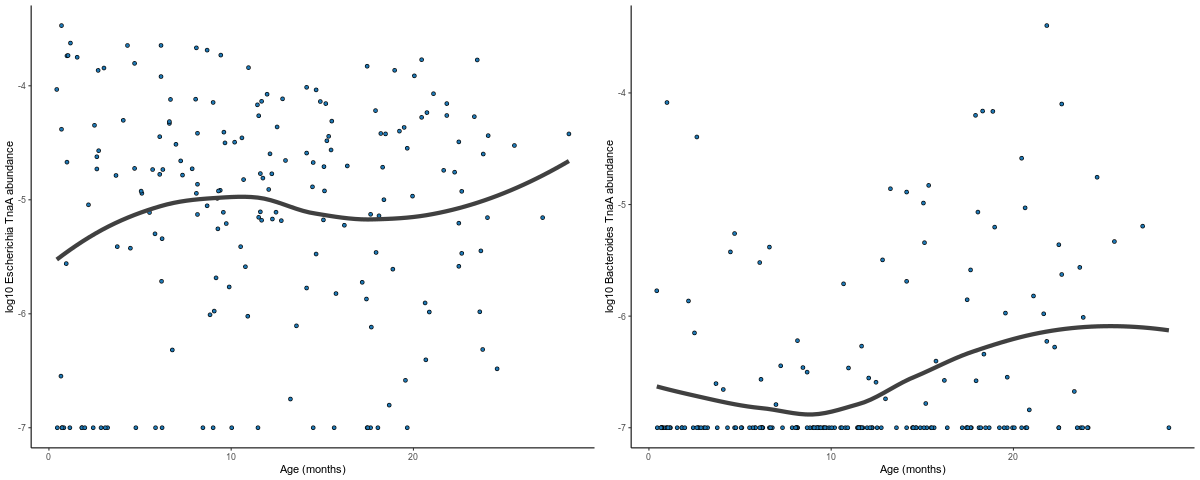

In [6]:
%%R -w 1200

library('ggplot2')
library('gridExtra')
source("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Aging_CF_Gut/Code_for_Figures/Lib/InfantAgeModels.R")

t <- improve_plot()
print(cor(df_dart$Age, log10(df_dart$read_frac_Escherichia + 1e-7), method = "spearman"))
print(cor.test(df_dart$Age, log10(df_dart$read_frac_Escherichia + 1e-7), method = "spearman")$p.value)

p1 <- ggplot(df_dart, aes(x = Age, y = log10(read_frac_Escherichia + 1e-7))) + geom_point(pch=21, fill="#1F78B4") + theme_classic() + geom_smooth(se=FALSE, color="#404040", lwd=2, alpha=10, method="loess") +
                ylab("log10 Escherichia TnaA abundance") + xlab("Age (months)")

print(cor(df_dart$Age, log10(df_dart$read_frac_Bacteroides + 1e-7), method = "spearman"))
print(cor.test(df_dart$Age, log10(df_dart$read_frac_Bacteroides + 1e-7), method = "spearman")$p.value)

p2 <- ggplot(df_dart, aes(x = Age, y = log10(read_frac_Bacteroides + 1e-7))) + geom_point(pch=21, fill="#1F78B4") + theme_classic() + geom_smooth(se=FALSE, color="#404040", lwd=2, alpha=10, method="loess") +
              ylab("log10 Bacteroides TnaA abundance")  + xlab("Age (months)")

grid.arrange(p1, p2, ncol=2)

# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Dart_Ecoli_TnaA_Abundance_over_time_240417.pdf", p1, width = 4, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Dart_Bacteroides_TnaA_Abundance_over_time_240417.pdf", p2, width = 4, height = 4)


[1] 0.9787473
[1] 3.012014e-129
[1] 0.6268872
[1] 8.181635e-22


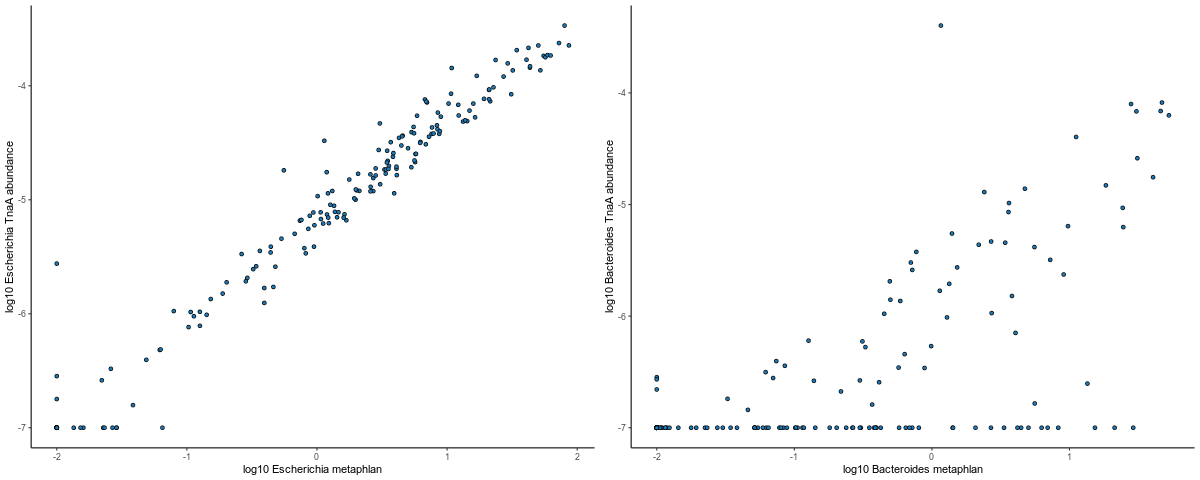

In [7]:
%%R -w 1200

library('ggplot2')
library('gridExtra')

# print(head(df_dart))

print(cor(df_dart$g__Escherichia, log10(df_dart$read_frac_Escherichia + 1e-7), method = "spearman"))
print(cor.test(df_dart$g__Escherichia, log10(df_dart$read_frac_Escherichia + 1e-7), method = "spearman")$p.value)

p1 <- ggplot(df_dart, aes(x = log10(g__Escherichia + 1e-2), y = log10(read_frac_Escherichia + 1e-7))) + geom_point(pch=21, fill="#1F78B4") + theme_classic() +
                ylab("log10 Escherichia TnaA abundance") + xlab("log10 Escherichia metaphlan")

print(cor(df_dart$g__Bacteroides, log10(df_dart$read_frac_Bacteroides + 1e-7), method = "spearman"))
print(cor.test(df_dart$g__Bacteroides, log10(df_dart$read_frac_Bacteroides + 1e-7), method = "spearman")$p.value)

p2 <- ggplot(df_dart, aes(x = log10(g__Bacteroides + 1e-2), y = log10(read_frac_Bacteroides + 1e-7))) + geom_point(pch=21, fill="#1F78B4") + theme_classic() +
              ylab("log10 Bacteroides TnaA abundance")  + xlab("log10 Bacteroides metaphlan")

grid.arrange(p1, p2, ncol=2)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Dart_Ecoli_TnaA_Abundance_vs_metaphlan_240417.pdf", p1, width = 4, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Dart_Bacteroides_TnaA_Abundance_vs_metaphlan_240417.pdf", p2, width = 4, height = 4)



In [8]:
print(df_tnaA_genus.sum(1).sort_values())

Eubacterium                3.0
Propionibacterium         17.0
Oribacterium              56.0
Faecalibacterium          86.0
Alistipes                377.0
Desulfitobacterium       411.0
Fusobacterium           1554.0
Haemophilus             1620.0
Clostridium             3538.0
Anaerococcus            3629.0
Akkermansia             6116.0
Porphyromonas           7118.0
Bacteroides             9665.0
Escherichia           104760.0
dtype: float64


In [9]:
genus_sorted = pd.DataFrame(df_tnaA_genus.sum(1).sort_values(ascending = False))
print(genus_sorted)
df_tnaA_genus = pd.DataFrame(df_tnaA_genus)

%Rpush df_tnaA_genus
%Rpush genus_sorted

                           0
Escherichia         104760.0
Bacteroides           9665.0
Porphyromonas         7118.0
Akkermansia           6116.0
Anaerococcus          3629.0
Clostridium           3538.0
Haemophilus           1620.0
Fusobacterium         1554.0
Desulfitobacterium     411.0
Alistipes              377.0
Faecalibacterium        86.0
Oribacterium            56.0
Propionibacterium       17.0
Eubacterium              3.0


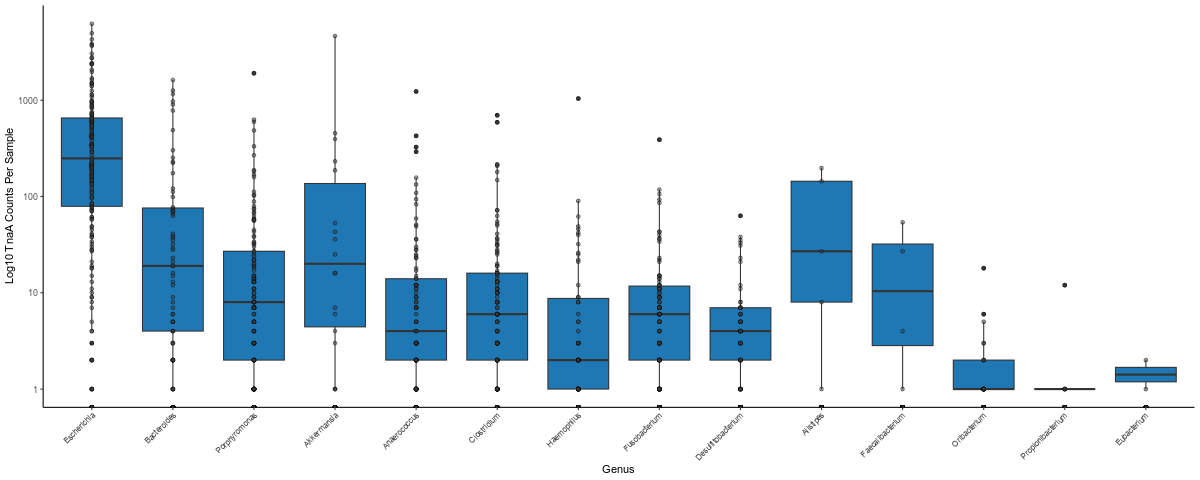

In [10]:
%%R -w 1200
df_tnaA_genus$Genus <- rownames(df_tnaA_genus)
genera_sorted <- rownames(genus_sorted)
df_tnaA_genus$Genus <- factor(df_tnaA_genus$Genus, levels = genera_sorted)
tnaA_plot <- pivot_longer(df_tnaA_genus, cols = -Genus, names_to = "Sample", values_to = "Counts")


p1 <- ggplot(tnaA_plot, aes(x = Genus, y = Counts)) + geom_boxplot(fill = "#1F78B4") + geom_point(pch=21, fill="gray23", alpha = 0.5) + theme_classic() +
                ylab("Log10 TnaA Counts Per Sample") + xlab("Genus") + scale_y_continuous(trans = 'log10') + theme(axis.text.x = element_text(size = 8, angle = 45, hjust = 1), legend.position = 'none')

p1
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Dartmouth_TnaA_Counts_by_Genus_240417.pdf", p1, width = 8, height = 4)

### DIABIMMUNE

In [11]:
infile_metaphlan_vat = pd.read_excel("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Vatanen2016/Results/Vatanen_metaphlan_combined_g_relative_abundance.xlsx", index_col=0)
infile_metaphlan_kos = pd.read_excel("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Kostic2015/Results/Kostic_metaphlan_combined_g_relative_abundance.xlsx", index_col=0)
infile_metaphlan_yas = pd.read_excel("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Yassour2016/Results/Yassour_metaphlan_combined_g_relative_abundance.xlsx", index_col=0)
infile_metaphlan_diab = pd.merge(infile_metaphlan_vat, infile_metaphlan_kos, on='clade', how='outer') 
df_species_rel_ab = pd.merge(infile_metaphlan_diab, infile_metaphlan_yas, on='clade', how='outer')
df_species_rel_ab.columns = [x.replace("_metaphlan_rel_ab_w_read_stats.txt","") for x in df_species_rel_ab]
df_species_rel_ab.index = [x.split("|")[-1] for x in df_species_rel_ab.index]

infile_metaphlan_vat = pd.read_excel("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Vatanen2016/Results/Vatanen_metaphlan_combined_g_estimated_number_of_reads_from_the_clade.xlsx", index_col=0)
infile_metaphlan_kos = pd.read_excel("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Kostic2015/Results/Kostic_metaphlan_combined_g_estimated_number_of_reads_from_the_clade.xlsx", index_col=0)
infile_metaphlan_yas = pd.read_excel("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Yassour2016/Results/Yassour_metaphlan_combined_g_estimated_number_of_reads_from_the_clade.xlsx", index_col=0)
infile_metaphlan_diab = pd.merge(infile_metaphlan_vat, infile_metaphlan_kos, on='clade', how='outer') 
df_species_totals = pd.merge(infile_metaphlan_diab, infile_metaphlan_yas, on='clade', how='outer')
df_species_totals.columns = [x.replace("_metaphlan_rel_ab_w_read_stats.txt","") for x in df_species_totals]

df_tnaA_vat = pd.read_csv("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Vatanen2016/Results/Vatanen_Diamond_TnaA_read_sum_30_Genus.csv",index_col=0)
df_tnaA_kos = pd.read_csv("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Kostic2015/Results/Kostic_Diamond_TnaA_read_sum_30_Genus.csv",index_col=0)
df_tnaA_yas = pd.read_csv("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Yassour2016/Results/Yassour_Diamond_TnaA_read_sum_30_Genus.csv",index_col=0)
df_tnaA = pd.concat([df_tnaA_vat, df_tnaA_kos, df_tnaA_yas], axis=1)
df_tnaA.columns = [x.replace("_Diamond_TnaA.tsv","") for x in df_tnaA.columns]

df_tnaA_genus_vat = pd.read_csv("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Vatanen2016/Results/Vatanen_Diamond_TnaA_best_hit_80_Genus.csv", index_col=0)
df_tnaA_genus_kos = pd.read_csv("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Kostic2015/Results/Kostic_Diamond_TnaA_best_hit_80_Genus.csv", index_col=0)
df_tnaA_genus_yas = pd.read_csv("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Yassour2016/Results/Yassour_Diamond_TnaA_best_hit_80_Genus.csv", index_col=0)
df_tnaA_genus = pd.concat([df_tnaA_genus_vat, df_tnaA_genus_kos, df_tnaA_genus_yas], axis=1) 
df_tnaA_genus.columns = [x.replace("_Diamond_TnaA.tsv","") for x in df_tnaA_genus.columns]

In [12]:
def get_genus_hits(df_tnaA_genus, df_species_totals, genera_oi):
    df_genus_oi = df_tnaA_genus.loc[genera_oi,:].T
    df_genus_oi = df_genus_oi.merge(df_species_totals.T["k__Bacteria"], left_index=True, right_index=True)
    for genus in genera_oi:
        df_genus_oi["read_frac_{}".format(genus)] = df_genus_oi[genus] / df_genus_oi["k__Bacteria"] 
    return df_genus_oi

def add_bulk_hits(df, df_tnaA):
    df = df.merge(df_tnaA.T, left_index=True, right_index=True)
    df["read_sum_frac"] = df["read_sum"] / df["k__Bacteria"]
    return df

def add_metaphlan(df, df_species_rel_ab, genera_oi = None):
    if genera_oi is None:
        df_metaphlan = df_species_rel_ab.T
    else:
        df_metaphlan = df_species_rel_ab.query('index in @genera_oi').T
    return df.merge(df_metaphlan, left_index=True, right_index=True)

def add_metadata(df):
    indir = Path("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/CF_Metagenomics_Manuscript/Tables")
    infile_meta = indir / "All_metadata_with_individuals_final_231222.csv"
    df_meta = pd.read_csv(infile_meta)
    df_meta = df_meta[["Sample","Individual","Age"]]
    df_meta.index = df_meta["Sample"]
    df_meta.drop(columns=["Sample"],inplace=True)
    return df.merge(df_meta, left_index=True, right_index=True)

df_tnaA_genus = sum_species_counts(df_tnaA_genus, ['Escherichia', 'Shigella'], 'Escherichia')
df_diab = get_genus_hits(df_tnaA_genus, df_species_totals, ["Bacteroides","Escherichia"])
df_diab = add_bulk_hits(df_diab, df_tnaA)
df_diab = add_metaphlan(df_diab, df_species_rel_ab, ["g__Bacteroides","g__Escherichia"])
df_diab = add_metadata(df_diab)
print(df_diab)

%Rpush df_diab

              Bacteroides  Escherichia  k__Bacteria  read_frac_Bacteroides  \
E000823_1.8           0.0          2.0      21215.0               0.000000   
E000823_12.5         88.0          0.0    4119585.0               0.000021   
E000823_24.3         32.0          0.0    1677077.0               0.000019   
E000823_35.0        341.0          0.0    5183750.0               0.000066   
E001958_11.8        198.0          7.0    7002309.0               0.000028   
...                   ...          ...          ...                    ...   
G80619                0.0          1.0    4922486.0               0.000000   
G80620                0.0         97.0    3287806.0               0.000000   
G80621              280.0        411.0    1638973.0               0.000171   
G80623                0.0          0.0    4358793.0               0.000000   
G80624               63.0          2.0    5085185.0               0.000012   

              read_frac_Escherichia  read_sum  read_sum_frac  g


	Spearman's rank correlation rho

data:  df_diab$Age and log10(df_diab$read_sum_frac + 1e-07)
S = 202138143, p-value = 4.656e-13
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2108085 

`geom_smooth()` using formula = 'y ~ x'


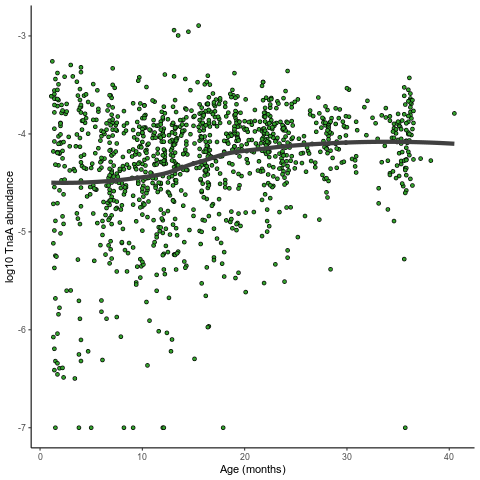

In [13]:
%%R
library(tidyverse)
library(ggplot2)
print(cor.test(df_diab$Age, log10(df_diab$read_sum_frac + 1e-7), method="spearman"))
p1 <- ggplot(df_diab, aes(x = Age, y = log10(read_sum_frac + 1e-7))) + geom_point(pch=21, fill="#33A02C") + theme_classic() + geom_smooth(se=FALSE, color="#404040", lwd=2, alpha=10, method="loess") +
                ylab("log10 TnaA abundance") + xlab("Age (months)")
print(p1)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Diab_total_TnaA_Abundance_over_time_240417.pdf", p1, width = 4, height = 4)


[1] -0.4087482
[1] 1.063618e-47
[1] 0.4117271
[1] 1.943315e-48
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


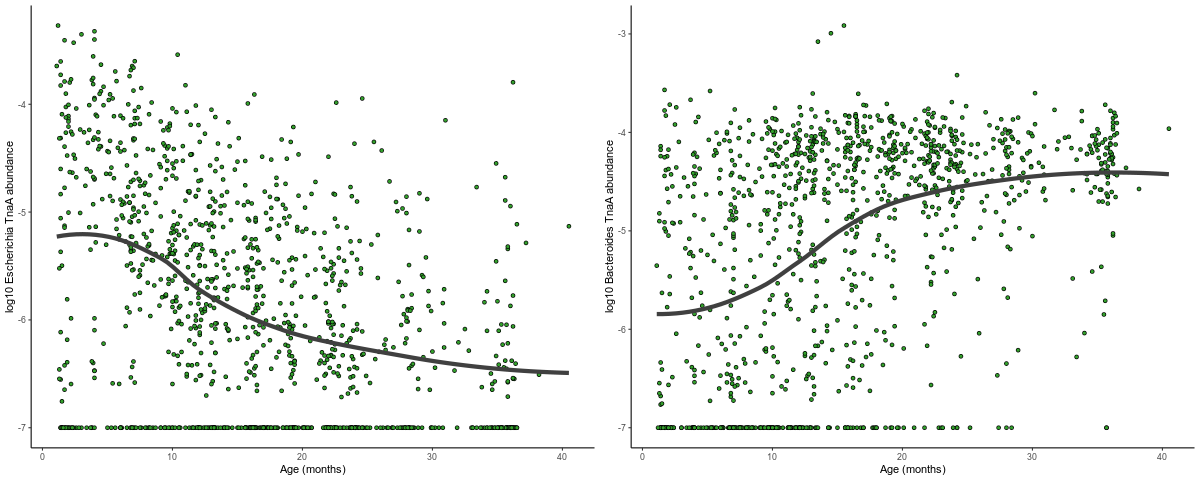

In [14]:
%%R -w 1200

library('ggplot2')
library('gridExtra')
source("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Aging_CF_Gut/Code_for_Figures/Lib/InfantAgeModels.R")

t <- improve_plot()
print(cor(df_diab$Age, log10(df_diab$read_frac_Escherichia + 1e-7), method = "spearman"))
print(cor.test(df_diab$Age, log10(df_diab$read_frac_Escherichia + 1e-7), method = "spearman")$p.value)

p1 <- ggplot(df_diab, aes(x = Age, y = log10(read_frac_Escherichia + 1e-7))) + geom_point(pch=21, fill="#33A02C") + theme_classic() + geom_smooth(se=FALSE, color="#404040", lwd=2, alpha=10, method="loess") +
                ylab("log10 Escherichia TnaA abundance") + xlab("Age (months)")

print(cor(df_diab$Age, log10(df_diab$read_frac_Bacteroides + 1e-7), method = "spearman"))
print(cor.test(df_diab$Age, log10(df_diab$read_frac_Bacteroides + 1e-7), method = "spearman")$p.value)

p2 <- ggplot(df_diab, aes(x = Age, y = log10(read_frac_Bacteroides + 1e-7))) + geom_point(pch=21, fill="#33A02C") + theme_classic() + geom_smooth(se=FALSE, color="#404040", lwd=2, alpha=10, method="loess") +
              ylab("log10 Bacteroides TnaA abundance")  + xlab("Age (months)")

grid.arrange(p1, p2, ncol=2)

# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Diab_Ecoli_TnaA_Abundance_over_time_240417.pdf", p1, width = 4, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Diab_Bacteroides_TnaA_Abundance_over_time_240417.pdf", p2, width = 4, height = 4)



[1] 0.9326569
[1] 0
[1] 0.5756018
[1] 8.648565e-103


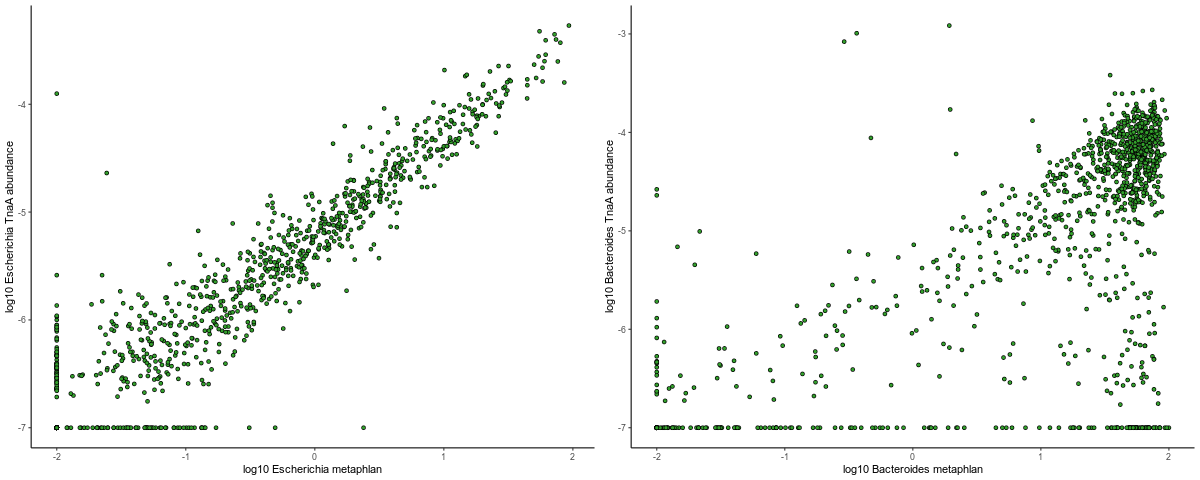

In [15]:
%%R -w 1200

library('ggplot2')
library('gridExtra')

# print(head(df))

print(cor(df_diab$g__Escherichia, log10(df_diab$read_frac_Escherichia + 1e-7), method = "spearman"))
print(cor.test(df_diab$g__Escherichia, log10(df_diab$read_frac_Escherichia + 1e-7), method = "spearman")$p.value)

p1 <- ggplot(df_diab, aes(x = log10(g__Escherichia + 1e-2), y = log10(read_frac_Escherichia + 1e-7))) + geom_point(pch=21, fill="#33A02C") + theme_classic() +
                ylab("log10 Escherichia TnaA abundance") + xlab("log10 Escherichia metaphlan")

print(cor(df_diab$g__Bacteroides, log10(df_diab$read_frac_Bacteroides + 1e-7), method = "spearman"))
print(cor.test(df_diab$g__Bacteroides, log10(df_diab$read_frac_Bacteroides + 1e-7), method = "spearman")$p.value)

p2 <- ggplot(df_diab, aes(x = log10(g__Bacteroides + 1e-2), y = log10(read_frac_Bacteroides + 1e-7))) + geom_point(pch=21, fill="#33A02C") + theme_classic() +
              ylab("log10 Bacteroides TnaA abundance")  + xlab("log10 Bacteroides metaphlan")

grid.arrange(p1, p2, ncol=2)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Diab_Ecoli_TnaA_Abundance_vs_metaphlan_240417.pdf", p1, width = 4, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Diab_Bacteroides_TnaA_Abundance_vs_metaphlan_240417.pdf", p2, width = 4, height = 4)


In [16]:
print(df_tnaA_genus.sum(1).sort_values())

Symbiobacterium           19.0
Brachyspira               34.0
Propionibacterium         39.0
Eubacterium               88.0
Oribacterium             235.0
Shuttleworthia           240.0
Desulfitobacterium      1082.0
Haemophilus             1657.0
Anaerococcus            3478.0
Fusobacterium           4690.0
Clostridium             4862.0
Faecalibacterium        5861.0
Alistipes              16799.0
Porphyromonas          23024.0
Akkermansia            42517.0
Escherichia            83253.0
Bacteroides           258892.0
dtype: float64


In [17]:
genus_sorted = pd.DataFrame(df_tnaA_genus.sum(1).sort_values(ascending = False))
print(genus_sorted)
df_tnaA_genus = pd.DataFrame(df_tnaA_genus)

%Rpush df_tnaA_genus
%Rpush genus_sorted

                           0
Bacteroides         258892.0
Escherichia          83253.0
Akkermansia          42517.0
Porphyromonas        23024.0
Alistipes            16799.0
Faecalibacterium      5861.0
Clostridium           4862.0
Fusobacterium         4690.0
Anaerococcus          3478.0
Haemophilus           1657.0
Desulfitobacterium    1082.0
Shuttleworthia         240.0
Oribacterium           235.0
Eubacterium             88.0
Propionibacterium       39.0
Brachyspira             34.0
Symbiobacterium         19.0


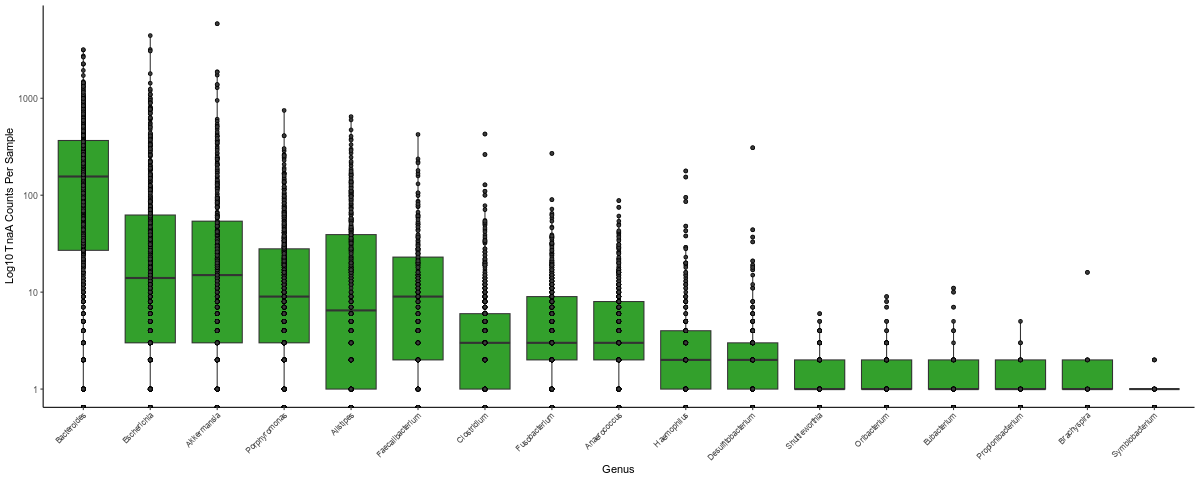

In [18]:
%%R -w 1200
df_tnaA_genus$Genus <- rownames(df_tnaA_genus)
genera_sorted <- rownames(genus_sorted)
df_tnaA_genus$Genus <- factor(df_tnaA_genus$Genus, levels = genera_sorted)
tnaA_plot <- pivot_longer(df_tnaA_genus, cols = -Genus, names_to = "Sample", values_to = "Counts")


p1 <- ggplot(tnaA_plot, aes(x = Genus, y = Counts)) + geom_boxplot(fill = "#33A02C") + geom_point(pch=21, fill="gray23") + scale_fill_viridis_d() + theme_classic() +
                ylab("Log10 TnaA Counts Per Sample") + xlab("Genus") + scale_y_continuous(trans = 'log10') + theme(axis.text.x = element_text(size = 8, angle = 45, hjust = 1), legend.position = 'none')

p1
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Diabimmune_TnaA_Counts_by_Genus_240417.pdf", p1, width = 8, height = 4)

### TEDDY

In [19]:
infile_metaphlan = "/dartfs/rc/lab/R/RossB/OtherLabsPublished/TEDDY/Results/TEDDY_metaphlan_combined_g_estimated_number_of_reads_from_the_clade.xlsx"
df_species_totals = pd.read_excel(infile_metaphlan, index_col="clade")
df_species_totals.columns = [x.split("_")[0] for x in df_species_totals.columns]

infile_metaphlan = "/dartfs/rc/lab/R/RossB/OtherLabsPublished/TEDDY/Results/TEDDY_metaphlan_combined_g_relative_abundance.xlsx"
df_species_rel_ab = pd.read_excel(infile_metaphlan, index_col="clade")
df_species_rel_ab.columns = [x.split("_")[0] for x in df_species_rel_ab.columns]
df_species_rel_ab.index = [x.split("|")[-1] for x in df_species_rel_ab.index]

df_tnaA = pd.read_csv("/dartfs/rc/lab/R/RossB/OtherLabsPublished/TEDDY/Results/TEDDY_Diamond_TnaA_read_sum_30_Genus.csv",index_col=0)
df_tnaA.columns = [x.replace("_Diamond_TnaA.tsv","") for x in df_tnaA.columns]

df_tnaA_genus = pd.read_csv("/dartfs/rc/lab/R/RossB/OtherLabsPublished/TEDDY/Results/TEDDY_Diamond_TnaA_best_hit_80_Genus.csv",index_col=0)
df_tnaA_genus.columns = [x.replace("_Diamond_TnaA.tsv","") for x in df_tnaA_genus.columns]
df_tnaA_genus

,SAMN09413948,SAMN09411704,SAMN09417045,SAMN09412341,SAMN09414035,SAMN09411603,SAMN09421053,SAMN09417964,SAMN09414074,SAMN09417039,...,SAMN09415416,SAMN09413699,SAMN09415410,SAMN09418426,SAMN09412013,SAMN09410612,SAMN09415437,SAMN09412571,SAMN09411635,SAMN09412931
Porphyromonas,1.0,89.0,4.0,1.0,2.0,5.0,4.0,0.0,0.0,1.0,...,1.0,0.0,1.0,4.0,0.0,2.0,2.0,0.0,4.0,12.0
Bacteroides,17.0,11.0,1.0,0.0,69.0,2.0,0.0,0.0,0.0,29.0,...,13.0,169.0,52.0,1.0,0.0,40.0,49.0,51.0,92.0,26.0
Clostridium,1.0,15.0,0.0,0.0,5.0,1.0,9.0,0.0,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,4.0,1.0,4.0,7.0,2.0
Fusobacterium,1.0,0.0,1.0,3.0,3.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,6.0,0.0,5.0,10.0,0.0,7.0,6.0
Haemophilus,0.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Shigella,0.0,1.0,29.0,144.0,29.0,7.0,24.0,74.0,16.0,67.0,...,6.0,49.0,18.0,19.0,320.0,0.0,0.0,0.0,0.0,7.0
Desulfitobacterium,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0
Anaerococcus,0.0,0.0,3.0,4.0,1.0,5.0,0.0,2.0,0.0,0.0,...,1.0,0.0,5.0,3.0,0.0,4.0,4.0,0.0,5.0,1.0
Escherichia,0.0,0.0,1.0,16.0,4.0,1.0,4.0,9.0,3.0,10.0,...,0.0,6.0,1.0,0.0,20.0,0.0,0.0,0.0,0.0,1.0
Shuttleworthia,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
def get_genus_hits(df_tnaA_genus, df_species_totals, genera_oi):
    df_genus_oi = df_tnaA_genus.loc[genera_oi,:].T
    df_genus_oi = df_genus_oi.merge(df_species_totals.T["k__Bacteria"], left_index=True, right_index=True)
    for genus in genera_oi:
        df_genus_oi["read_frac_{}".format(genus)] = df_genus_oi[genus] / df_genus_oi["k__Bacteria"] 
    return df_genus_oi

def add_bulk_hits(df, df_tnaA):
    df = df.merge(df_tnaA.T, left_index=True, right_index=True)
    df["read_sum_frac"] = df["read_sum"] / df["k__Bacteria"]
    return df

def add_metaphlan(df, df_species_rel_ab, genera_oi = None):
    if genera_oi is None:
        df_metaphlan = df_species_rel_ab.T
    else:
        df_metaphlan = df_species_rel_ab.query('index in @genera_oi').T
    return df.merge(df_metaphlan, left_index=True, right_index=True)

def add_metadata(df):
    indir = Path("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/CF_Metagenomics_Manuscript/Tables")
    infile_meta = indir / "All_metadata_with_individuals_final_231222.csv"
    df_meta = pd.read_csv(infile_meta)
    df_meta = df_meta[["Sample","Individual","Age"]]
    df_meta.index = df_meta["Sample"]
    df_meta.drop(columns=["Sample"],inplace=True)
    return df.merge(df_meta, left_index=True, right_index=True)

df_tnaA_genus = sum_species_counts(df_tnaA_genus, ['Escherichia', 'Shigella'], 'Escherichia')
df_teddy = get_genus_hits(df_tnaA_genus, df_species_totals, ["Bacteroides","Escherichia"])
df_teddy = add_bulk_hits(df_teddy, df_tnaA)
df_teddy = add_metaphlan(df_teddy, df_species_rel_ab, ["g__Bacteroides","g__Escherichia"])
df_teddy = add_metadata(df_teddy)
print(df_teddy)

%Rpush df_teddy

              Bacteroides  Escherichia  k__Bacteria  read_frac_Bacteroides  \
SAMN09408007          0.0         10.0      8004384           0.000000e+00   
SAMN09408015          0.0          0.0      5812079           0.000000e+00   
SAMN09408030          1.0          0.0      5162279           1.937129e-07   
SAMN09408031         46.0          3.0      5249904           8.762065e-06   
SAMN09408041        119.0        526.0      4438363           2.681169e-05   
...                   ...          ...          ...                    ...   
SAMN09421166          0.0        449.0      5624405           0.000000e+00   
SAMN09421175          0.0         10.0      4640626           0.000000e+00   
SAMN09421179          8.0          1.0      5221697           1.532069e-06   
SAMN09421187         19.0          6.0      4875396           3.897119e-06   
SAMN09421204          0.0          2.0      3802730           0.000000e+00   

              read_frac_Escherichia  read_sum  read_sum_frac  g


	Spearman's rank correlation rho

data:  df_teddy$Age and log10(df_teddy$read_sum_frac + 1e-07)
S = 250631433, p-value = 1.86e-15
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2226208 

`geom_smooth()` using formula = 'y ~ x'


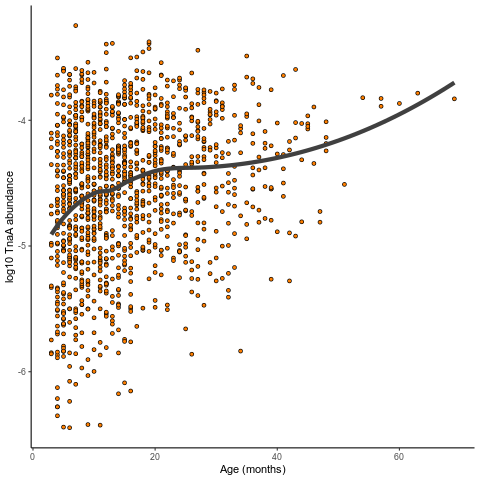

In [21]:
%%R
library(tidyverse)
library(ggplot2)
print(cor.test(df_teddy$Age, log10(df_teddy$read_sum_frac + 1e-7), method="spearman"))
p1 <- ggplot(df_teddy, aes(x = Age, y = log10(read_sum_frac + 1e-7))) + geom_point(pch=21, fill="#FF7F00") + theme_classic() + geom_smooth(se=FALSE, color="#404040", lwd=2, alpha=10, method="loess") +
                ylab("log10 TnaA abundance") + xlab("Age (months)")
print(p1)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/TEDDY_total_TnaA_Abundance_over_time_240417.pdf", p1, width = 4, height = 4)


[1] -0.3146627
[1] 4.881222e-30
[1] 0.346297
[1] 2.017248e-36
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


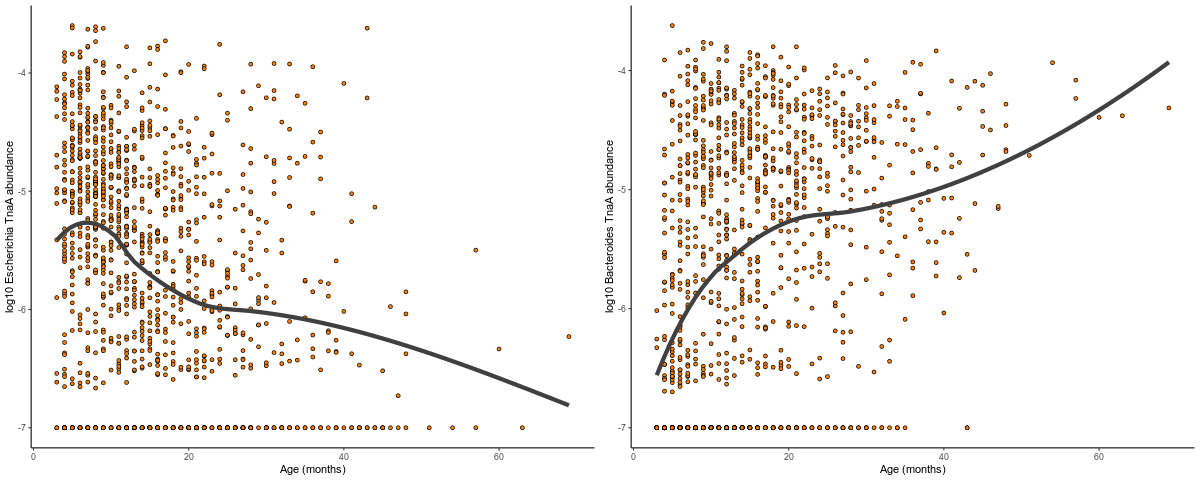

In [22]:
%%R -w 1200

library('ggplot2')
library('gridExtra')
source("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Aging_CF_Gut/Code_for_Figures/Lib/InfantAgeModels.R")

t <- improve_plot()
print(cor(df_teddy$Age, log10(df_teddy$read_frac_Escherichia + 1e-7), method = "spearman"))
print(cor.test(df_teddy$Age, log10(df_teddy$read_frac_Escherichia + 1e-7), method = "spearman")$p.value)

p1 <- ggplot(df_teddy, aes(x = Age, y = log10(read_frac_Escherichia + 1e-7))) + geom_point(pch=21, fill="#FF7F00") + theme_classic() + geom_smooth(se=FALSE, color="#404040", lwd=2, alpha=10, method="loess") +
                ylab("log10 Escherichia TnaA abundance") + xlab("Age (months)")

print(cor(df_teddy$Age, log10(df_teddy$read_frac_Bacteroides + 1e-7), method = "spearman"))
print(cor.test(df_teddy$Age, log10(df_teddy$read_frac_Bacteroides + 1e-7), method = "spearman")$p.value)

p2 <- ggplot(df_teddy, aes(x = Age, y = log10(read_frac_Bacteroides + 1e-7))) + geom_point(pch=21, fill="#FF7F00") + theme_classic() + geom_smooth(se=FALSE, color="#404040", lwd=2, alpha=10, method="loess") +
              ylab("log10 Bacteroides TnaA abundance")  + xlab("Age (months)")

grid.arrange(p1, p2, ncol=2)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/TEDDY_Ecoli_TnaA_Abundance_over_time_240417.pdf", p1, width = 4, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/TEDDY_Bacteroides_TnaA_Abundance_over_time_240417.pdf", p2, width = 4, height = 4)


[1] 0.9618468
[1] 0
[1] 0.8044043
[1] 1.299826e-283


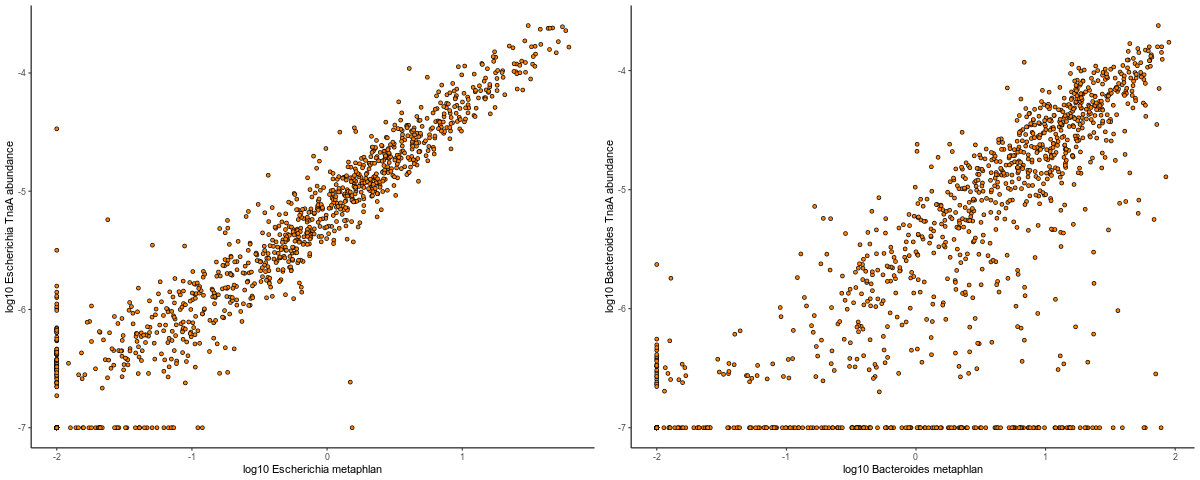

In [23]:
%%R -w 1200

library('ggplot2')
library('gridExtra')

# print(head(df))

print(cor(df_teddy$g__Escherichia, log10(df_teddy$read_frac_Escherichia + 1e-7), method = "spearman"))
print(cor.test(df_teddy$g__Escherichia, log10(df_teddy$read_frac_Escherichia + 1e-7), method = "spearman")$p.value)

p1 <- ggplot(df_teddy, aes(x = log10(g__Escherichia + 1e-2), y = log10(read_frac_Escherichia + 1e-7))) + geom_point(pch=21, fill="#FF7F00") + theme_classic() +
                ylab("log10 Escherichia TnaA abundance") + xlab("log10 Escherichia metaphlan")

print(cor(df_teddy$g__Bacteroides, log10(df_teddy$read_frac_Bacteroides + 1e-7), method = "spearman"))
print(cor.test(df_teddy$g__Bacteroides, log10(df_teddy$read_frac_Bacteroides + 1e-7), method = "spearman")$p.value)

p2 <- ggplot(df_teddy, aes(x = log10(g__Bacteroides + 1e-2), y = log10(read_frac_Bacteroides + 1e-7))) + geom_point(pch=21, fill="#FF7F00") + theme_classic() +
              ylab("log10 Bacteroides TnaA abundance")  + xlab("log10 Bacteroides metaphlan")

grid.arrange(p1, p2, ncol=2)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/TEDDY_Ecoli_TnaA_Abundance_vs_metaphlan_240417.pdf", p1, width = 4, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/TEDDY_Bacteroides_TnaA_Abundance_vs_metaphlan_240417.pdf", p2, width = 4, height = 4)


In [24]:
print(df_tnaA_genus.sum(1).sort_values())

Propionibacterium         14.0
Eubacterium               19.0
Symbiobacterium           21.0
Brachyspira               92.0
Oribacterium             230.0
Shuttleworthia           343.0
Haemophilus              573.0
Desulfitobacterium       971.0
Faecalibacterium        3228.0
Clostridium             4737.0
Anaerococcus            5222.0
Fusobacterium           6163.0
Alistipes               6986.0
Porphyromonas           9938.0
Akkermansia            56864.0
Escherichia            91840.0
Bacteroides           106585.0
dtype: float64


In [25]:
genus_sorted = pd.DataFrame(df_tnaA_genus.sum(1).sort_values(ascending = False))
print(genus_sorted)
df_tnaA_genus = pd.DataFrame(df_tnaA_genus)

%Rpush df_tnaA_genus
%Rpush genus_sorted

                           0
Bacteroides         106585.0
Escherichia          91840.0
Akkermansia          56864.0
Porphyromonas         9938.0
Alistipes             6986.0
Fusobacterium         6163.0
Anaerococcus          5222.0
Clostridium           4737.0
Faecalibacterium      3228.0
Desulfitobacterium     971.0
Haemophilus            573.0
Shuttleworthia         343.0
Oribacterium           230.0
Brachyspira             92.0
Symbiobacterium         21.0
Eubacterium             19.0
Propionibacterium       14.0


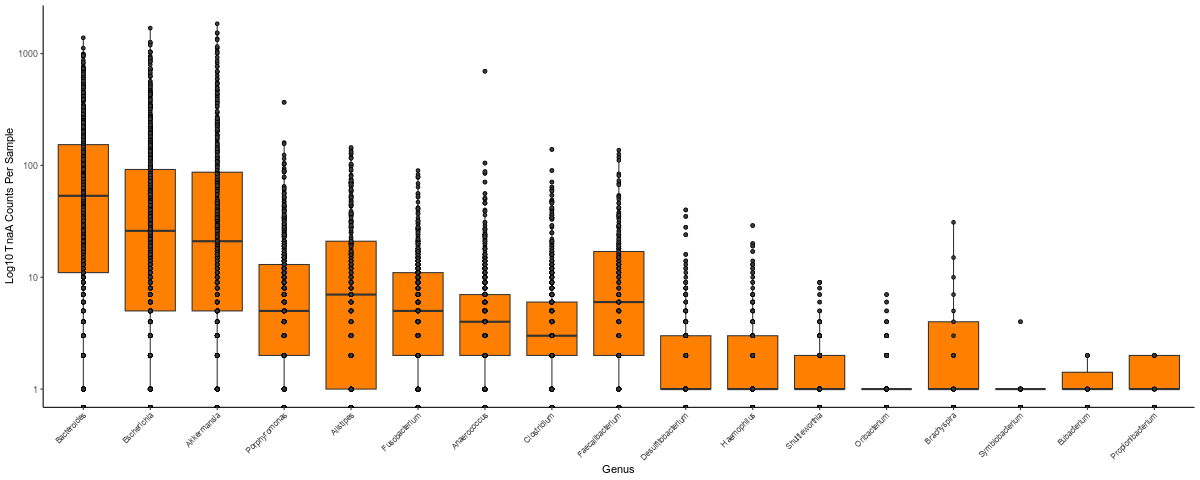

In [26]:
%%R -w 1200
df_tnaA_genus$Genus <- rownames(df_tnaA_genus)
genera_sorted <- rownames(genus_sorted)
df_tnaA_genus$Genus <- factor(df_tnaA_genus$Genus, levels = genera_sorted)
tnaA_plot <- pivot_longer(df_tnaA_genus, cols = -Genus, names_to = "Sample", values_to = "Counts")


p1 <- ggplot(tnaA_plot, aes(x = Genus, y = Counts)) + geom_boxplot(fill = "#FF7F00") + geom_point(pch=21, fill="gray23") + scale_fill_viridis_d() + theme_classic() +
                ylab("Log10 TnaA Counts Per Sample") + xlab("Genus") + scale_y_continuous(trans = 'log10') + theme(axis.text.x = element_text(size = 8, angle = 45, hjust = 1), legend.position = 'none')

p1
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/TEDDY_TnaA_Counts_by_Genus_240417.pdf", p1, width = 8, height = 4)

### Hayden

In [14]:
df_species_rel_ab = pd.read_excel("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Hayden2020/Results/Hayden_metaphlan_combined_g.xlsx", index_col=0)
df_species_rel_ab.columns = [x.replace("_metaphlan.txt","") for x in df_species_rel_ab]
df_species_rel_ab.index = [x.split("|")[-1] for x in df_species_rel_ab.index]

df_species_totals = pd.read_excel("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Hayden2020/Results/Hayden_metaphlan_combined_g_estimated_number_of_reads_from_the_clade.xlsx", index_col=0)
df_species_totals.columns = [x.replace("_metaphlan_rel_ab_w_read_stats.txt","") for x in df_species_totals]

df_tnaA = pd.read_csv("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Hayden2020/Results/Hayden_Diamond_TnaA_read_sum_30_Genus.csv",index_col=0)
df_tnaA.columns = [x.replace("_Diamond_TnaA.tsv","") for x in df_tnaA.columns]

df_tnaA_genus = pd.read_csv("/dartfs/rc/lab/R/RossB/OtherLabsPublished/Hayden2020/Results/Hayden_Diamond_TnaA_best_hit_80_Genus.csv", index_col=0)
df_tnaA_genus.columns = [x.replace("_Diamond_TnaA.tsv","") for x in df_tnaA_genus.columns]
df_tnaA_genus

,SRR8428065,SRR8353610,SRR8353955,SRR8428118,SRR8353886,SRR8353864,SRR8354177,SRR8427733,SRR8354045,SRR8427557,...,SRR8353810,SRR8427858,SRR8353925,SRR8427831,SRR8353736,SRR8353857,SRR8353845,SRR8427894,SRR8353982,SRR8353777
Shigella,259.0,27.0,99.0,357.0,107.0,284.0,0.0,188.0,480.0,936.0,...,22.0,1040.0,0.0,404.0,40.0,1.0,548.0,137.0,166.0,164.0
Porphyromonas,41.0,9.0,0.0,0.0,0.0,0.0,0.0,523.0,1.0,4.0,...,2.0,2.0,0.0,0.0,1.0,27.0,1.0,0.0,3.0,0.0
Escherichia,20.0,3.0,10.0,31.0,8.0,16.0,0.0,17.0,23.0,43.0,...,0.0,54.0,0.0,20.0,1.0,0.0,39.0,5.0,14.0,22.0
Anaerococcus,11.0,2.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0,2.0,...,8.0,0.0,1.0,0.0,1.0,0.0,1.0,6.0,0.0,0.0
Oribacterium,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0
Fusobacterium,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,2.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0
Clostridium,0.0,1.0,1.0,25.0,0.0,1.0,9.0,5.0,1.0,13.0,...,0.0,1.0,0.0,8.0,0.0,1.0,7.0,0.0,0.0,0.0
Bacteroides,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,3.0,...,11.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Desulfitobacterium,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Haemophilus,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0,0.0


In [17]:
def sum_species_counts(df_tnaA_genus, species_to_merge, new_species_name):
    missing_species = [species for species in species_to_merge if species not in df_tnaA_genus.index]
    if missing_species:
        raise ValueError(f"Missing species in DataFrame: {missing_species}")
    df_tnaA_genus.loc[new_species_name] = df_tnaA_genus.loc[species_to_merge].sum()
    species_to_drop = [species for species in species_to_merge if species != new_species_name]
    df_tnaA_genus = df_tnaA_genus.drop(species_to_drop)
    return df_tnaA_genus

def get_genus_hits(df_tnaA_genus, df_species_totals, genera_oi):
    df_genus_oi = df_tnaA_genus.loc[genera_oi,:].T
    df_genus_oi = df_genus_oi.merge(df_species_totals.T["k__Bacteria"], left_index=True, right_index=True)
    for genus in genera_oi:
        df_genus_oi["read_frac_{}".format(genus)] = df_genus_oi[genus] / df_genus_oi["k__Bacteria"] 
    return df_genus_oi

def add_bulk_hits(df, df_tnaA):
    df = df.merge(df_tnaA.T, left_index=True, right_index=True)
    df["read_sum_frac"] = df["read_sum"] / df["k__Bacteria"]
    return df

def add_metaphlan(df, df_species_rel_ab, genera_oi = None):
    if genera_oi is None:
        df_metaphlan = df_species_rel_ab.T
    else:
        df_metaphlan = df_species_rel_ab.query('index in @genera_oi').T
    return df.merge(df_metaphlan, left_index=True, right_index=True)

# For all samples
# def add_metadata(df):
#     indir = Path("/dartfs/rc/lab/R/RossB/SalernoP/CF_Metabolomics/")
#     infile_meta = indir / "Hayden_metadata.xlsx"
#     df_meta = pd.read_excel(infile_meta)
#     df_meta = df_meta[["SRR","Indv","month"]].rename(columns={"month":"Age", "Indv":"Individual", "SRR":"Sample"})
#     df_meta.index = df_meta["Sample"]
#     df_meta.drop(columns=["Sample"],inplace=True)
#     return df.merge(df_meta, left_index=True, right_index=True)

# Specifically for metabolomics data
def add_metadata(df):
    indir = Path("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/")
    infile_meta = indir / "metabolomics_metadata_230620.csv"
    df_meta = pd.read_csv(infile_meta)
    df_meta = df_meta[["SRR","subject.id","Age"]].rename(columns={"subject.id":"Individual", "SRR":"Sample"})
    df_meta.index = df_meta["Sample"]
    df_meta.drop(columns=["Sample"],inplace=True)
    return df.merge(df_meta, left_index=True, right_index=True)

# df_tnaA_genus = sum_species_counts(df_tnaA_genus, ['Escherichia', 'Shigella'], 'Escherichia')
df_hayden = get_genus_hits(df_tnaA_genus, df_species_totals, ["Bacteroides","Escherichia"])
df_hayden = add_bulk_hits(df_hayden, df_tnaA)
df_hayden = add_metaphlan(df_hayden, df_species_rel_ab, ["g__Bacteroides","g__Escherichia"])
df_hayden = add_metadata(df_hayden)

df_hayden['sample.type'] = np.where(df_hayden['Individual'].str.startswith('H'), 'Control',
                             np.where(df_hayden['Individual'].str.startswith('B'), 'CF', np.nan))

df_hayden_cf = df_hayden[df_hayden['sample.type'] == 'CF']
df_hayden_control = df_hayden[df_hayden['sample.type'] == 'Control']
print(df_hayden)
print(df_hayden['sample.type'].unique())

%Rpush df_hayden
%Rpush df_hayden_cf
%Rpush df_hayden_control

            Bacteroides  Escherichia  k__Bacteria  read_frac_Bacteroides  \
SRR8353610          1.0         30.0     15309037           6.532090e-08   
SRR8354011          0.0         45.0      5157536           0.000000e+00   
SRR8353949          0.0        263.0     10919944           0.000000e+00   
SRR8427669          0.0          3.0      5131145           0.000000e+00   
SRR8354184          0.0         53.0      5586605           0.000000e+00   
...                 ...          ...          ...                    ...   
SRR8353899          0.0        274.0     10016074           0.000000e+00   
SRR8427760          0.0        665.0     10221818           0.000000e+00   
SRR8354008          2.0         17.0      8835322           2.263641e-07   
SRR8427858          0.0       1094.0      8920476           0.000000e+00   
SRR8427831          0.0        424.0     14555807           0.000000e+00   

            read_frac_Escherichia  read_sum  read_sum_frac  g__Escherichia  \
SRR835361


	Spearman's rank correlation rho

data:  df_hayden$Age and log10(df_hayden$read_sum_frac + 1e-07)
S = 2263396, p-value = 0.6119
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.03319815 


	Spearman's rank correlation rho

data:  df_hayden_cf$Age and log10(df_hayden_cf$read_sum_frac + 1e-07)
S = 767386, p-value = 0.5521
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.04606197 


	Spearman's rank correlation rho

data:  df_hayden_control$Age and log10(df_hayden_control$read_sum_frac + 1e-07)
S = 65914, p-value = 0.009368
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.3152307 

`geom_smooth()` using formula = 'y ~ x'


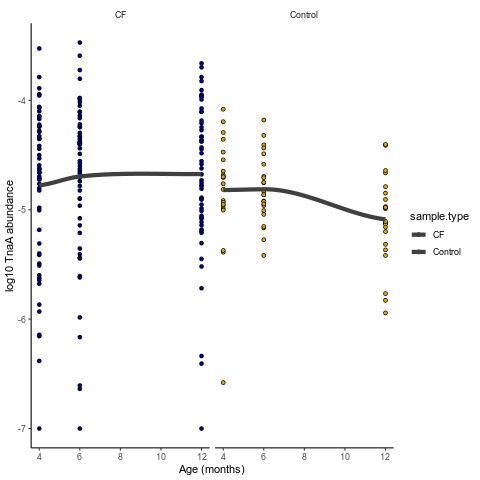

In [18]:
%%R
library(tidyverse)
library(ggplot2)

print(cor.test(df_hayden$Age, log10(df_hayden$read_sum_frac + 1e-7), method="spearman"))
print(cor.test(df_hayden_cf$Age, log10(df_hayden_cf$read_sum_frac + 1e-7), method="spearman"))
print(cor.test(df_hayden_control$Age, log10(df_hayden_control$read_sum_frac + 1e-7), method="spearman"))

p1 <- ggplot(df_hayden, aes(x = Age, y = log10(read_sum_frac + 1e-7), fill = sample.type)) + geom_point(pch=21) + theme_classic() + geom_smooth(se=FALSE, color="#404040", lwd=2, alpha=10, method="loess") +
                ylab("log10 TnaA abundance") + xlab("Age (months)") + facet_wrap(~sample.type) + theme(strip.background = element_blank()) + scale_fill_manual(values = c("#000080", "#DAA520")) +
                scale_x_continuous(breaks = c(2, 4, 6, 8, 10, 12))
print(p1)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_total_TnaA_Abundance_over_time_all_data_240422.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_total_TnaA_Abundance_over_time_metabolomics_only_240419.pdf", p1, width = 8, height = 4)


[1] 0.01020877
[1] 0.8760319
[1] 0.1084894
[1] 0.1603062
[1] -0.3133885
[1] 0.009813669
[1] 0.09416853
[1] 0.1492544
[1] 0.06254866
[1] 0.4191543
[1] 0.1542965
[1] 0.2125129
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


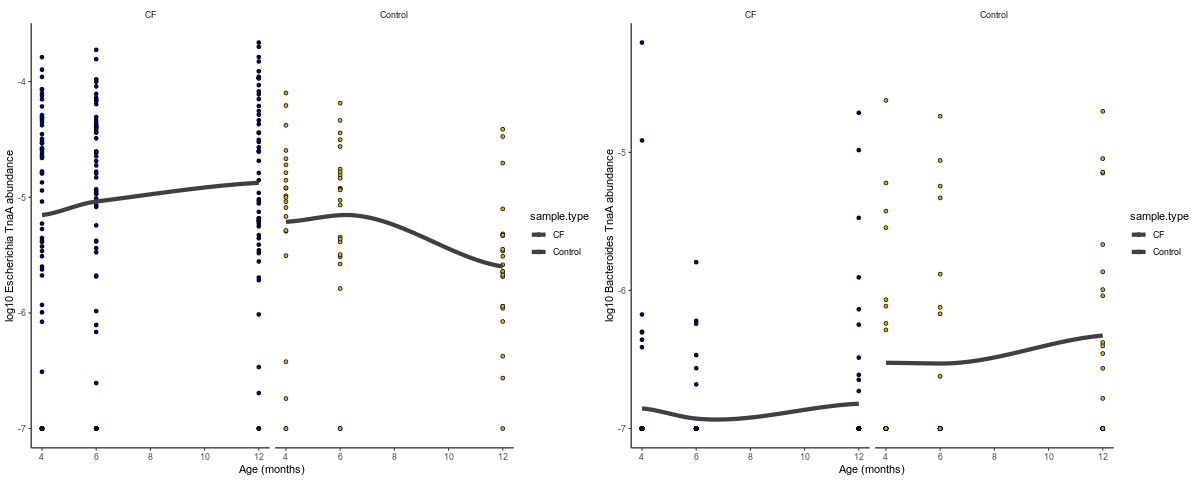

In [19]:
%%R -w 1200

library('ggplot2')
library('gridExtra')
source("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Aging_CF_Gut/Code_for_Figures/Lib/InfantAgeModels.R")

t <- improve_plot()
print(cor(df_hayden$Age, log10(df_hayden$read_frac_Escherichia + 1e-7), method = "spearman"))
print(cor.test(df_hayden$Age, log10(df_hayden$read_frac_Escherichia + 1e-7), method = "spearman")$p.value)

print(cor(df_hayden_cf$Age, log10(df_hayden_cf$read_frac_Escherichia + 1e-7), method = "spearman"))
print(cor.test(df_hayden_cf$Age, log10(df_hayden_cf$read_frac_Escherichia + 1e-7), method = "spearman")$p.value)

print(cor(df_hayden_control$Age, log10(df_hayden_control$read_frac_Escherichia + 1e-7), method = "spearman"))
print(cor.test(df_hayden_control$Age, log10(df_hayden_control$read_frac_Escherichia + 1e-7), method = "spearman")$p.value)


p1 <- ggplot(df_hayden, aes(x = Age, y = log10(read_frac_Escherichia + 1e-7), fill = sample.type)) + geom_point(pch=21) + theme_classic() + geom_smooth(se=FALSE, color="#404040", lwd=2, alpha=10, method="loess") +
                ylab("log10 Escherichia TnaA abundance") + xlab("Age (months)") + facet_wrap(~sample.type) + theme(strip.background = element_blank()) + scale_fill_manual(values = c("#000080", "#DAA520")) +
                scale_x_continuous(breaks = c(2, 4, 6, 8, 10, 12))

print(cor(df_hayden$Age, log10(df_hayden$read_frac_Bacteroides + 1e-7), method = "spearman"))
print(cor.test(df_hayden$Age, log10(df_hayden$read_frac_Bacteroides + 1e-7), method = "spearman")$p.value)

print(cor(df_hayden_cf$Age, log10(df_hayden_cf$read_frac_Bacteroides + 1e-7), method = "spearman"))
print(cor.test(df_hayden_cf$Age, log10(df_hayden_cf$read_frac_Bacteroides + 1e-7), method = "spearman")$p.value)

print(cor(df_hayden_control$Age, log10(df_hayden_control$read_frac_Bacteroides + 1e-7), method = "spearman"))
print(cor.test(df_hayden_control$Age, log10(df_hayden_control$read_frac_Bacteroides + 1e-7), method = "spearman")$p.value)


p2 <- ggplot(df_hayden, aes(x = Age, y = log10(read_frac_Bacteroides + 1e-7), fill = sample.type)) + geom_point(pch=21) + theme_classic() + geom_smooth(se=FALSE, color="#404040", lwd=2, alpha=10, method="loess") +
              ylab("log10 Bacteroides TnaA abundance")  + xlab("Age (months)") + facet_wrap(~sample.type) + theme(strip.background = element_blank()) + scale_fill_manual(values = c("#000080", "#DAA520")) +
                scale_x_continuous(breaks = c(2, 4, 6, 8, 10, 12))

grid.arrange(p1, p2, ncol=2)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_Ecoli_TnaA_Abundance_over_time_all_data_240422.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_Bacteroides_TnaA_Abundance_over_time_all_data_240422.pdf", p2, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_Ecoli_TnaA_Abundance_over_time_metabolomics_only_240419.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_Bacteroides_TnaA_Abundance_over_time_metabolomics_only_240419.pdf", p2, width = 8, height = 4)


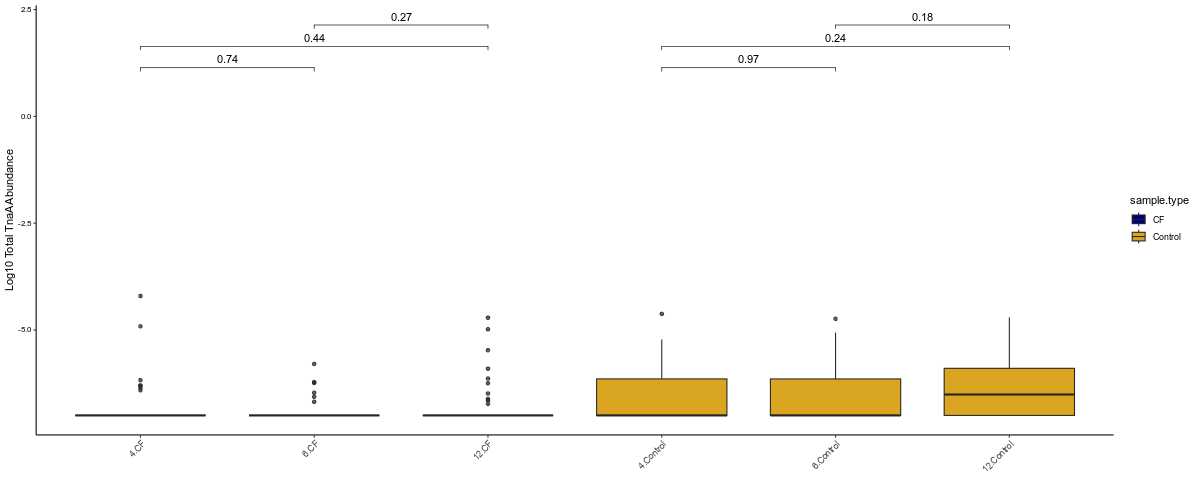

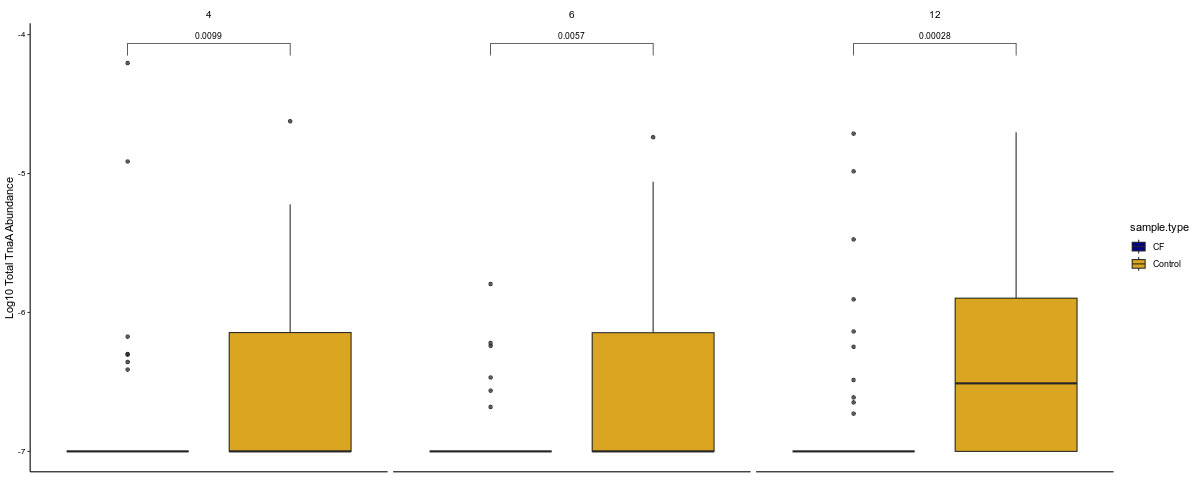

In [23]:
%%R -w 1200
library('ggplot2')
library('ggpubr')

CF_tests_all <- list(c("1.CF", "2.CF"), c("1.CF", "3.CF"), c("1.CF", "4.CF"), c("1.CF", "5.CF"), c("1.CF", "6.CF"), c("1.CF", "8.CF"), c("1.CF", "10.CF"), c("1.CF", "12.CF"))
CF_tests_metabolomics <- list(c("4.CF", "6.CF"), c("4.CF", "12.CF"), c("6.CF", "12.CF"))
Control_tests_all <- list(c("2.Control", "4.Control"), c("2.Control", "6.Control"), c("2.Control", "9.Control"), c("2.Control", "12.Control"))
Control_tests_metabolomics <- list(c("4.Control", "6.Control"), c("4.Control", "12.Control"), c("6.Control", "12.Control"))

                                   
p1 <- ggplot(df_hayden, aes(x = interaction(Age,sample.type), y = log10(read_frac_Bacteroides + 1e-7))) + geom_boxplot(aes(fill = sample.type), color = "gray15", outlier.alpha = 0.75) +
  theme_classic() +
  scale_fill_manual(values = c("#000080", "#DAA520")) +
  stat_compare_means(
  aes(label = ..p.format..), 
  comparisons = CF_tests_metabolomics,
  label.y = c(1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5),
  method = "wilcox.test") + 
  stat_compare_means(
  aes(label = ..p.format..), 
  comparisons = Control_tests_metabolomics,
  label.y = c(1, 1.5, 2, 2.5),
  method = "wilcox.test") +
  theme(strip.background = element_blank(),
        axis.text.y = element_text(color = "black", size = 8),
        strip.text = element_text(color = "black", size = 10),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(y = "Log10 Total TnaA Abundance") 

print(p1)

test <- list(c("CF", "Control"))
filtered_data <- subset(df_hayden, Age %in% c(2, 4, 6, 12))

p2 <- ggplot(filtered_data, aes(sample.type, log10(read_frac_Bacteroides + 1e-7))) +
  geom_boxplot(aes(fill = sample.type), color = "gray15", outlier.alpha = 0.75) +
  facet_wrap(~Age, ncol = 4, scale = "free_x") +
  theme_classic() +
  scale_fill_manual(values = c("#000080", "#DAA520")) +
  stat_compare_means(method = "wilcox.test",
                     label = "p.format",
                     tip.length = 0.03,
                     comparisons = test,
                     hide.ns = F,
                     size = 3) +
  theme(strip.background = element_blank(),
        axis.text.y = element_text(color = "black", size = 8),
        strip.text = element_text(color = "black", size = 10),
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank()) +
  labs(y = "Log10 Total TnaA Abundance")
 
print(p2)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_boxplot_Bacteroides_TnaA_Abundance_over_time_all_data_240419.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_boxplot_Bacteroides_TnaA_Abundance_over_time_cf_vs_control_all_data_240419.pdf", p2, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_boxplot_Bacteroides_TnaA_Abundance_over_time_metabolomics_only_240419.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_boxplot_Bacteroides_TnaA_Abundance_over_time_cf_vs_control_metabolomics_only_240422.pdf", p2, width = 8, height = 4)


# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_boxplot_Escherichia_TnaA_Abundance_over_time_all_data_240419.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_boxplot_Escherichia_TnaA_Abundance_over_time_cf_vs_control_all_data_240419.pdf", p2, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_boxplot_Escherichia_TnaA_Abundance_over_time_metabolomics_only_240419.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_boxplot_Escherichia_TnaA_Abundance_over_time_cf_vs_control_metabolomics_only_240419.pdf", p2, width = 8, height = 4)


# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_boxplot_TnaA_Abundance_over_time_all_data_240419.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_boxplot_TnaA_Abundance_over_time_cf_vs_control_all_data_240419.pdf", p2, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_boxplot_TnaA_Abundance_over_time_metabolomics_only_240419.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_boxplot_TnaA_Abundance_over_time_cf_vs_control_metabolomics_only_240419.pdf", p2, width = 8, height = 4)


[1] 0.972613
[1] 9.394071e-108
[1] 0.9832322
[1] 9.142244e-50
[1] 0.5258148
[1] 2.121649e-13
[1] 0.5648719
[1] 6.37647e-07


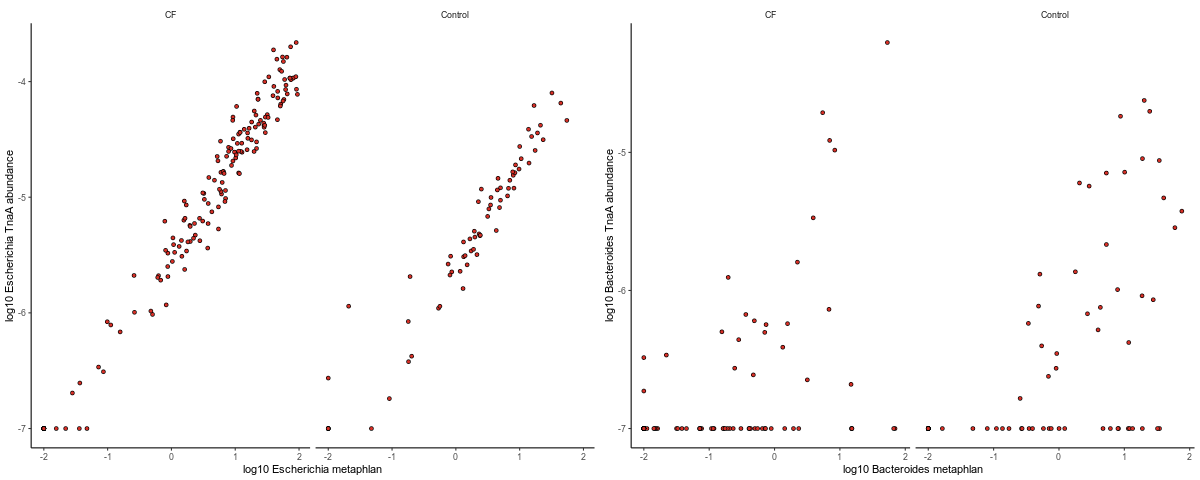

In [21]:
%%R -w 1200

library('ggplot2')
library('gridExtra')

# print(head(df))

# print(cor(df_hayden$g__Escherichia, log10(df_hayden$read_frac_Escherichia + 1e-7), method = "spearman"))
# print(cor.test(df_hayden$g__Escherichia, log10(df_hayden$read_frac_Escherichia + 1e-7), method = "spearman")$p.value)

print(cor(df_hayden_cf$g__Escherichia, log10(df_hayden_cf$read_frac_Escherichia + 1e-7), method = "spearman"))
print(cor.test(df_hayden_cf$g__Escherichia, log10(df_hayden_cf$read_frac_Escherichia + 1e-7), method = "spearman")$p.value)

print(cor(df_hayden_control$g__Escherichia, log10(df_hayden_control$read_frac_Escherichia + 1e-7), method = "spearman"))
print(cor.test(df_hayden_control$g__Escherichia, log10(df_hayden_control$read_frac_Escherichia + 1e-7), method = "spearman")$p.value)

p1 <- ggplot(df_hayden, aes(x = log10(g__Escherichia + 1e-2), y = log10(read_frac_Escherichia + 1e-7))) + geom_point(pch=21, fill="#D73027") + theme_classic() +
                ylab("log10 Escherichia TnaA abundance") + xlab("log10 Escherichia metaphlan") + facet_wrap(~sample.type) + theme(strip.background = element_blank())

# print(cor(df_hayden$g__Bacteroides, log10(df_hayden$read_frac_Bacteroides + 1e-7), method = "spearman"))
# print(cor.test(df_hayden$g__Bacteroides, log10(df_hayden$read_frac_Bacteroides + 1e-7), method = "spearman")$p.value)

print(cor(df_hayden_cf$g__Bacteroides, log10(df_hayden_cf$read_frac_Bacteroides + 1e-7), method = "spearman"))
print(cor.test(df_hayden_cf$g__Bacteroides, log10(df_hayden_cf$read_frac_Bacteroides + 1e-7), method = "spearman")$p.value)

print(cor(df_hayden_control$g__Bacteroides, log10(df_hayden_control$read_frac_Bacteroides + 1e-7), method = "spearman"))
print(cor.test(df_hayden_control$g__Bacteroides, log10(df_hayden_control$read_frac_Bacteroides + 1e-7), method = "spearman")$p.value)

p2 <- ggplot(df_hayden, aes(x = log10(g__Bacteroides + 1e-2), y = log10(read_frac_Bacteroides + 1e-7))) + geom_point(pch=21, fill="#D73027") + theme_classic() +
              ylab("log10 Bacteroides TnaA abundance")  + xlab("log10 Bacteroides metaphlan") + facet_wrap(~sample.type) + theme(strip.background = element_blank())

grid.arrange(p1, p2, ncol=2)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_Ecoli_TnaA_Abundance_vs_metaphlan_all_data_240419.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_Bacteroides_TnaA_Abundance_vs_metaphlan_all_data_240419.pdf", p2, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_Ecoli_TnaA_Abundance_vs_metaphlan_metabolomics_only_240419.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_Bacteroides_TnaA_Abundance_vs_metaphlan_metabolomics_only_240419.pdf", p2, width = 8, height = 4)


In [125]:
df_tnaA_genus = pd.DataFrame(df_tnaA_genus)
cf_columns = df_hayden[df_hayden['sample.type'] == 'CF'].index
df_cf = df_tnaA_genus[cf_columns]
genus_sorted_cf = pd.DataFrame(df_cf.sum(1).sort_values(ascending = False))
print(genus_sorted_cf)

control_columns = df_hayden[df_hayden['sample.type'] == 'Control'].index
df_control = df_tnaA_genus[control_columns]
genus_sorted_control = pd.DataFrame(df_control.sum(1).sort_values(ascending = False))
print(genus_sorted_control)

%Rpush df_cf
%Rpush genus_sorted_cf
%Rpush df_control
%Rpush genus_sorted_control

                           0
Escherichia         307231.0
Akkermansia          16503.0
Porphyromonas        15268.0
Bacteroides           9886.0
Clostridium           5326.0
Anaerococcus          3317.0
Fusobacterium         2453.0
Haemophilus           2371.0
Desulfitobacterium     720.0
Faecalibacterium       637.0
Oribacterium           321.0
Alistipes               84.0
Shuttleworthia          78.0
Propionibacterium       33.0
Brachyspira             15.0
Eubacterium             12.0
Symbiobacterium          2.0
                          0
Escherichia         15440.0
Bacteroides          4054.0
Akkermansia          2831.0
Porphyromonas        1420.0
Clostridium           869.0
Anaerococcus          181.0
Fusobacterium         140.0
Desulfitobacterium    117.0
Haemophilus           105.0
Alistipes              23.0
Faecalibacterium       19.0
Oribacterium           17.0
Shuttleworthia         10.0
Brachyspira             2.0
Propionibacterium       1.0
Eubacterium             0.0
Sy

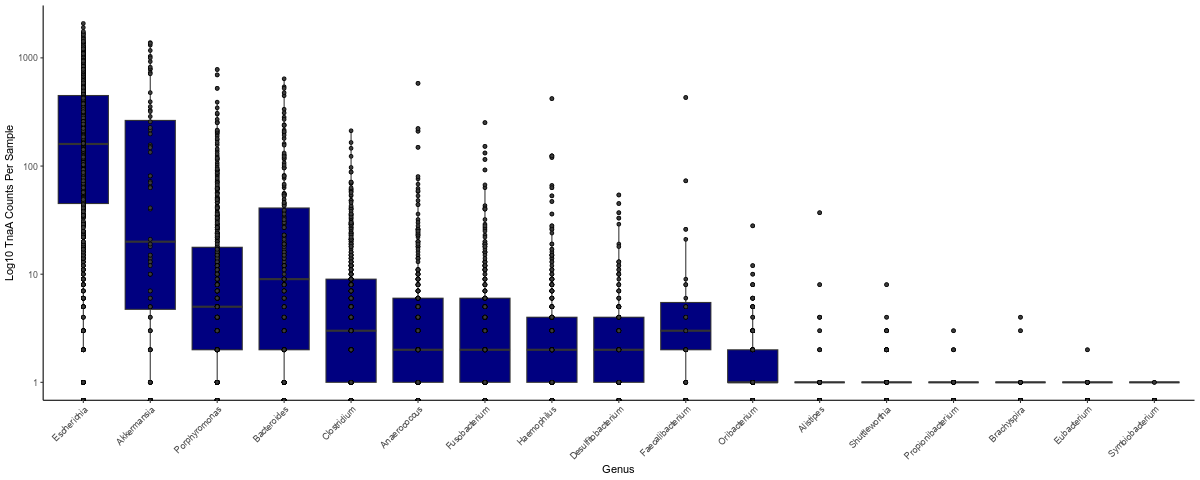

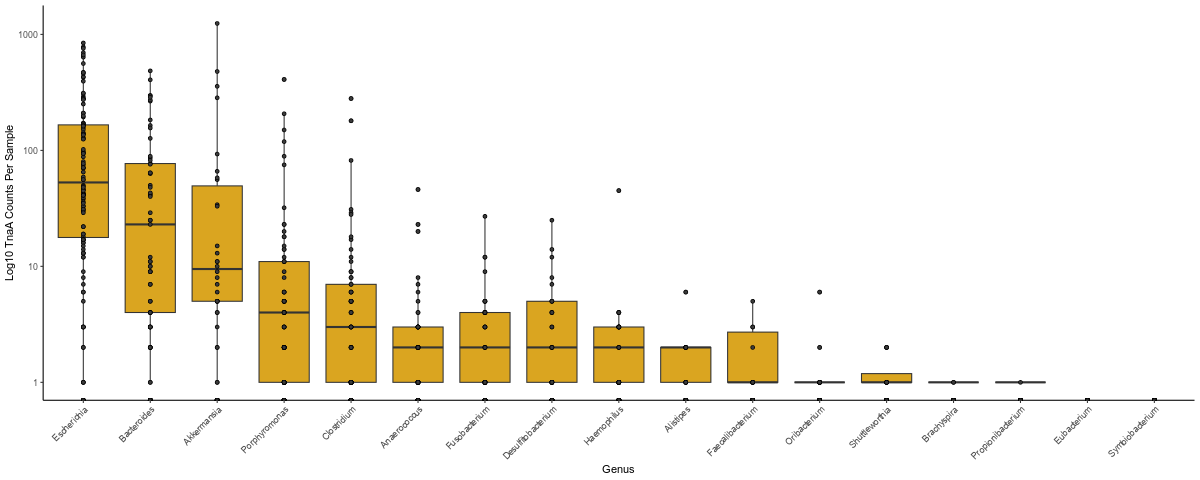

In [126]:
%%R -w 1200
library(viridis)
df_cf$Genus <- rownames(df_cf)
genera_sorted_cf <- rownames(genus_sorted_cf)
df_cf$Genus <- factor(df_cf$Genus, levels = genera_sorted_cf)
tnaA_plot_cf <- pivot_longer(df_cf, cols = -Genus, names_to = "Sample", values_to = "Counts")


p1 <- ggplot(tnaA_plot_cf, aes(x = Genus, y = Counts)) + geom_boxplot(fill = "#000080") + geom_point(pch=21, fill="gray23")+ theme_classic() +
                ylab("Log10 TnaA Counts Per Sample") + xlab("Genus") + scale_y_continuous(trans = 'log10') + theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(p1)

df_control$Genus <- rownames(df_control)
genus_sorted_control <- rownames(genus_sorted_control)
df_control$Genus <- factor(df_control$Genus, levels = genus_sorted_control)
tnaA_plot_control <- pivot_longer(df_control, cols = -Genus, names_to = "Sample", values_to = "Counts")


p2 <- ggplot(tnaA_plot_control, aes(x = Genus, y = Counts)) + geom_boxplot(fill =  "#DAA520") + geom_point(pch=21, fill="gray23") + theme_classic() +
                ylab("Log10 TnaA Counts Per Sample") + xlab("Genus") + scale_y_continuous(trans = 'log10') + theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(p2)

# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_CF_TnaA_Abundance_by_genus_all_data_240419.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_Healthy_TnaA_Abundance_by_genus_all_data_240419.pdf", p2, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_CF_TnaA_Abundance_by_genus_metabolomics_only_240419.pdf", p1, width = 8, height = 4)
# ggsave("/dartfs/rc/lab/R/RossB/SalernoP/metagenomics_data_backup/Metabolomics/Hayden_Healthy_TnaA_Abundance_by_genus_metabolomics_only_240419.pdf", p2, width = 8, height = 4)


## Comparisons Between Two Datasets

### Dartmouth vs DIABIMMUNE

In [34]:
from scipy.stats import ranksums
import numpy as np
vals1 = df_dart["read_sum_frac"].values
vals2 = df_diab["read_sum_frac"].values
print(np.median(vals1), np.median(vals2))
ranksums(vals1, vals2)

3.133483922556894e-05 6.744664495439789e-05


RanksumsResult(statistic=-6.696587579717535, pvalue=2.1334261218980535e-11)

In [35]:
from sklearn.linear_model import LinearRegression
m = LinearRegression().fit( df_dart["Age"].values.reshape(-1,1), np.log10(df_dart["read_sum_frac"] + 1e-10).values.reshape(-1,1))
residuals_dart = m.predict( df_dart["Age"].values.reshape(-1,1)) - np.log10(df_dart["read_sum_frac"] + 1e-10).values.reshape(-1,1)

m = LinearRegression().fit( df_diab["Age"].values.reshape(-1,1), np.log10(df_diab["read_sum_frac"] + 1e-10).values.reshape(-1,1))
residuals_diab = m.predict( df_diab["Age"].values.reshape(-1,1)) - np.log10(df_diab["read_sum_frac"] + 1e-10).values.reshape(-1,1)

In [36]:
print(np.median(residuals_dart), np.median(residuals_diab))
ranksums(residuals_dart, residuals_diab)

-0.1497666870036607 -0.12316770019356627


RanksumsResult(statistic=-0.4219781458394848, pvalue=0.6730409691037598)

In [37]:
from scipy.stats import ranksums
import numpy as np
vals1 = df_dart.query('Age >= 18')["read_sum_frac"].values
vals2 = df_diab.query('Age >= 18')["read_sum_frac"].values
print(np.median(vals1), np.median(vals2))
ranksums(vals1, vals2)

3.8862341509470044e-05 8.676851097136009e-05


RanksumsResult(statistic=-5.039796879341406, pvalue=4.660261899265661e-07)

In [38]:
from scipy.stats import ranksums
import numpy as np
vals1 = df_dart.query('Age >= 12')["read_sum_frac"].values
vals2 = df_diab.query('Age >= 12')["read_sum_frac"].values
print(np.median(vals1), np.median(vals2))
ranksums(vals1, vals2)

3.0285193801273277e-05 8.026500413414625e-05


RanksumsResult(statistic=-7.061872363207772, pvalue=1.6427384886744911e-12)

### Dartmouth vs. TEDDY

In [39]:
from scipy.stats import ranksums
import numpy as np
vals1 = df_dart["read_sum_frac"].values
vals2 = df_teddy["read_sum_frac"].values
print(np.median(vals1), np.median(vals2))
ranksums(vals1, vals2)

3.133483922556894e-05 3.453861410837269e-05


RanksumsResult(statistic=-1.2219719916536307, pvalue=0.22171821885219223)

In [40]:
from sklearn.linear_model import LinearRegression
m = LinearRegression().fit( df_dart["Age"].values.reshape(-1,1), np.log10(df_dart["read_sum_frac"] + 1e-10).values.reshape(-1,1))
residuals_dart = m.predict( df_dart["Age"].values.reshape(-1,1)) - np.log10(df_dart["read_sum_frac"] + 1e-10).values.reshape(-1,1)

m = LinearRegression().fit( df_teddy["Age"].values.reshape(-1,1), np.log10(df_teddy["read_sum_frac"] + 1e-10).values.reshape(-1,1))
residuals_teddy = m.predict( df_teddy["Age"].values.reshape(-1,1)) - np.log10(df_teddy["read_sum_frac"] + 1e-10).values.reshape(-1,1)

In [41]:
print(np.median(residuals_dart), np.median(residuals_teddy))
ranksums(residuals_dart, residuals_teddy)

-0.1497666870036607 -0.059524012987147046


RanksumsResult(statistic=-1.1609491967850716, pvalue=0.24566256022666766)

In [42]:
from scipy.stats import ranksums
import numpy as np
vals1 = df_dart.query('Age >= 18')["read_sum_frac"].values
vals2 = df_teddy.query('Age >= 18')["read_sum_frac"].values
print(np.median(vals1), np.median(vals2))
ranksums(vals1, vals2)

3.8862341509470044e-05 4.709930417613159e-05


RanksumsResult(statistic=-1.5599939403595298, pvalue=0.11876131317780839)

In [43]:
from scipy.stats import ranksums
import numpy as np
vals1 = df_dart.query('Age >= 12')["read_sum_frac"].values
vals2 = df_teddy.query('Age >= 12')["read_sum_frac"].values
print(np.median(vals1), np.median(vals2))
ranksums(vals1, vals2)

3.0285193801273277e-05 4.173913855671896e-05


RanksumsResult(statistic=-2.799388418664525, pvalue=0.005119950839649585)

### Dartmouth vs. Hayden CF

In [44]:
from scipy.stats import ranksums
import numpy as np
df_dart_12 = df_dart.query('Age <= 12')
vals1 = df_dart_12["read_sum_frac"].values
vals2 = df_hayden_cf["read_sum_frac"].values
print(np.median(vals1), np.median(vals2))
ranksums(vals1, vals2)

3.2524787214255956e-05 2.361609072330729e-05


RanksumsResult(statistic=1.712906192375494, pvalue=0.0867297988839675)

In [45]:
from sklearn.linear_model import LinearRegression
m = LinearRegression().fit( df_dart_12["Age"].values.reshape(-1,1), np.log10(df_dart_12["read_sum_frac"] + 1e-10).values.reshape(-1,1))
residuals_dart = m.predict( df_dart_12["Age"].values.reshape(-1,1)) - np.log10(df_dart_12["read_sum_frac"] + 1e-10).values.reshape(-1,1)

m = LinearRegression().fit( df_hayden_cf["Age"].values.reshape(-1,1), np.log10(df_hayden_cf["read_sum_frac"] + 1e-10).values.reshape(-1,1))
residuals_hayden_cf = m.predict( df_hayden_cf["Age"].values.reshape(-1,1)) - np.log10(df_hayden_cf["read_sum_frac"] + 1e-10).values.reshape(-1,1)

In [46]:
print(np.median(residuals_dart), np.median(residuals_hayden_cf))
ranksums(residuals_dart, residuals_hayden_cf)

-0.10805573903521903 -0.2451909740199918


RanksumsResult(statistic=0.8277830290603423, pvalue=0.40779338746730187)

### Dartmouth vs. Hayden Control

In [47]:
from scipy.stats import ranksums
import numpy as np
df_dart_12 = df_dart.query('Age <= 12')
vals1 = df_dart_12["read_sum_frac"].values
vals2 = df_hayden_control["read_sum_frac"].values
print(np.median(vals1), np.median(vals2))
ranksums(vals1, vals2)

3.2524787214255956e-05 1.3332033872013254e-05


RanksumsResult(statistic=3.805299818728274, pvalue=0.00014163252327970927)

In [48]:
from sklearn.linear_model import LinearRegression
m = LinearRegression().fit( df_dart_12["Age"].values.reshape(-1,1), np.log10(df_dart_12["read_sum_frac"] + 1e-10).values.reshape(-1,1))
residuals_dart = m.predict( df_dart_12["Age"].values.reshape(-1,1)) - np.log10(df_dart_12["read_sum_frac"] + 1e-10).values.reshape(-1,1)

m = LinearRegression().fit( df_hayden_control["Age"].values.reshape(-1,1), np.log10(df_hayden_control["read_sum_frac"] + 1e-10).values.reshape(-1,1))
residuals_hayden_control = m.predict( df_hayden_control["Age"].values.reshape(-1,1)) - np.log10(df_hayden_control["read_sum_frac"] + 1e-10).values.reshape(-1,1)

In [49]:
print(np.median(residuals_dart), np.median(residuals_hayden_control))
ranksums(residuals_dart, residuals_hayden_control)

-0.10805573903521903 -0.014530034040374229


RanksumsResult(statistic=-1.023782033422237, pvalue=0.30593823834877254)

### TEDDY vs. DIABIMMUNE

In [50]:
from scipy.stats import ranksums
import numpy as np
vals1 = df_teddy["read_sum_frac"].values
vals2 = df_diab["read_sum_frac"].values
print(np.median(vals1), np.median(vals2))
ranksums(vals1, vals2)

3.453861410837269e-05 6.744664495439789e-05


RanksumsResult(statistic=-11.508274329633455, pvalue=1.1985266971427187e-30)

In [51]:
from sklearn.linear_model import LinearRegression
m = LinearRegression().fit( df_teddy["Age"].values.reshape(-1,1), np.log10(df_teddy["read_sum_frac"] + 1e-10).values.reshape(-1,1))
residuals_teddy = m.predict( df_teddy["Age"].values.reshape(-1,1)) - np.log10(df_teddy["read_sum_frac"] + 1e-10).values.reshape(-1,1)

m = LinearRegression().fit( df_diab["Age"].values.reshape(-1,1), np.log10(df_diab["read_sum_frac"] + 1e-10).values.reshape(-1,1))
residuals_diab = m.predict( df_diab["Age"].values.reshape(-1,1)) - np.log10(df_diab["read_sum_frac"] + 1e-10).values.reshape(-1,1)

In [52]:
print(np.median(residuals_teddy), np.median(residuals_diab))
ranksums(residuals_teddy, residuals_diab)

-0.059524012987147046 -0.12316770019356627


RanksumsResult(statistic=1.8401541932925856, pvalue=0.06574560285318504)

In [53]:
from scipy.stats import ranksums
import numpy as np
vals1 = df_teddy.query('Age >= 18')["read_sum_frac"].values
vals2 = df_diab.query('Age >= 18')["read_sum_frac"].values
print(np.median(vals1), np.median(vals2))
ranksums(vals1, vals2)

4.709930417613159e-05 8.676851097136009e-05


RanksumsResult(statistic=-8.209331098223355, pvalue=2.224241051780484e-16)

In [54]:
from scipy.stats import ranksums
import numpy as np
vals1 = df_teddy.query('Age >= 12')["read_sum_frac"].values
vals2 = df_diab.query('Age >= 12')["read_sum_frac"].values
print(np.median(vals1), np.median(vals2))
ranksums(vals1, vals2)

4.173913855671896e-05 8.026500413414625e-05


RanksumsResult(statistic=-9.630437979401336, pvalue=5.947543063431726e-22)

### Hayden CF vs. Hayden Control

In [55]:
from scipy.stats import ranksums
import numpy as np
vals1 = df_hayden_cf["read_sum_frac"].values
vals2 = df_hayden_control["read_sum_frac"].values
print(np.median(vals1), np.median(vals2))
ranksums(vals1, vals2)

2.361609072330729e-05 1.3332033872013254e-05


RanksumsResult(statistic=2.483425855249627, pvalue=0.013012542047764093)

In [56]:
from sklearn.linear_model import LinearRegression
m = LinearRegression().fit( df_hayden_cf["Age"].values.reshape(-1,1), np.log10(df_hayden_cf["read_sum_frac"] + 1e-10).values.reshape(-1,1))
residuals_hayden_cf = m.predict( df_hayden_cf["Age"].values.reshape(-1,1)) - np.log10(df_hayden_cf["read_sum_frac"] + 1e-10).values.reshape(-1,1)

m = LinearRegression().fit( df_hayden_control["Age"].values.reshape(-1,1), np.log10(df_hayden_control["read_sum_frac"] + 1e-10).values.reshape(-1,1))
residuals_hayden_control = m.predict( df_hayden_control["Age"].values.reshape(-1,1)) - np.log10(df_hayden_control["read_sum_frac"] + 1e-10).values.reshape(-1,1)

In [57]:
print(np.median(residuals_hayden_cf), np.median(residuals_hayden_control))
ranksums(residuals_hayden_cf, residuals_hayden_control)

-0.2451909740199918 -0.014530034040374229


RanksumsResult(statistic=-2.4217483687058086, pvalue=0.015446041907056124)

## Looking at tnaA abundances over time

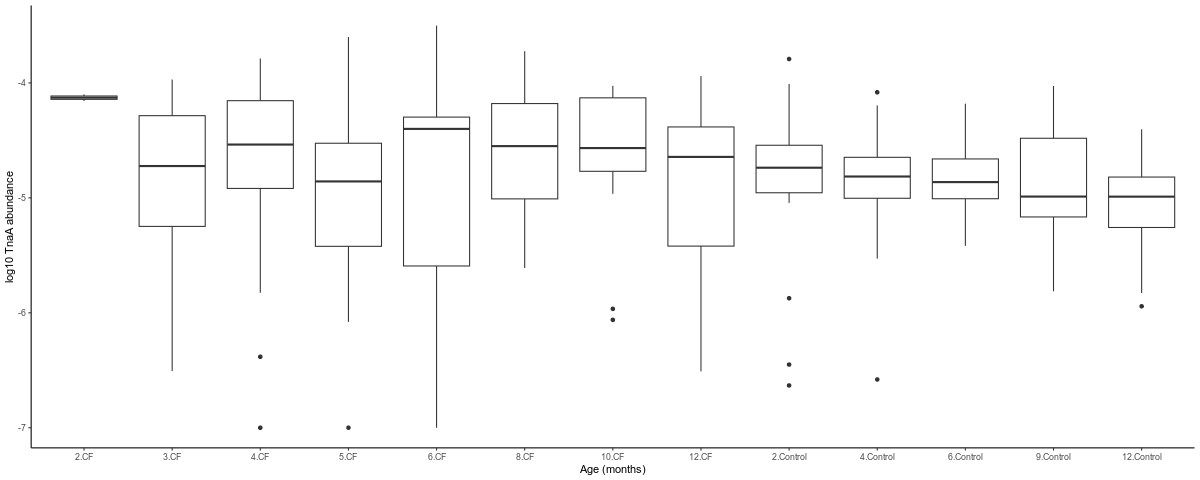

In [61]:
%%R -w 1200
library(ggplot2)
p1 <- ggplot(df_hayden, aes(x = interaction(as.factor(Age),sample.type), y = log10(read_sum_frac + 1e-7))) + geom_boxplot() + theme_classic() + ylab("log10 TnaA abundance") + xlab("Age (months)") + theme(strip.background = element_blank())
print(p1)
